# Dog Breed Classification 
## Dataset: Stanford Dogs Dataset

Number of images: 20,580</br>
Number of categories: 120 

Dataset reference:
http://vision.stanford.edu/aditya86/ImageNetDogs/

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import shutil
import sys
import xml.etree.ElementTree as ET
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

import tensorflow as tf
from tensorflow.keras.models import Model, load_model 
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications import Xception
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, GlobalMaxPooling2D, AveragePooling2D,Dropout, BatchNormalization, Activation, Conv2D
from tensorflow.keras.optimizers.schedules import CosineDecay, CosineDecayRestarts
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

from clr import OneCycleLR # local script, reference: https://github.com/titu1994/keras-one-cycle
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

### Helper function: Plot accuracy and loss curves

In [2]:
# Plots accuracy and loss plots
def evaluate_plots(history):
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    fig.set_size_inches(12,4)

    # Accuracy plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

## Preprocessing

### Create subset of the dataset for initial experiments (25% of the data chosen)

In [3]:
# Source and destinaiton folder
src = "data/images" 
#dst = os.path.join("data", "images_10") 
dst = os.path.join("data", "images_q25") 

# Create tje directory (print if exist)
if os.path.exists(dst):
    print(f"The directory already exists!")
else:
    os.mkdir(dst)
    print(f"Directory created!")

# Iterate over each dog breeds subfolder
for breed_name in os.listdir(src):
    breed_dir = os.path.join(src, breed_name)
    if os.path.isdir(breed_dir):
        files_all = os.listdir(breed_dir)               # All image files (unsorted)
        denom = 4                                        # Denominator variable to decide percenteage dynamicly
        files_keep = files_all[: len(files_all)//denom]  # Keep files (50%)

        # Dir
        target_dir = os.path.join(dst, breed_name)
        os.makedirs(target_dir, exist_ok=True)

        # Copy kept files (50% here)
        for f in files_keep:
            src_file = os.path.join(breed_dir, f)
            dst_file = os.path.join(target_dir, f)
            
            # Save
            with open(src_file, "rb") as sf, open(dst_file, "wb") as df:
                df.write(sf.read())

Directory created!


### Load dataset as dataframe

In [4]:
# Directory path of Stanford dataset images: Using 20 classes to investigate the limitations of the setup due to computally ressources
#ds_path = "data/Images"
ds_path = "data/Images_q25" # Local folder with 120 dog breeds but only 25% of the images

# Initialize lists for image path and label
imgs = []
breeds = []

# Iterate image directory and store image path and breed
for folder in os.listdir(ds_path):
    folder_path = os.path.join(ds_path, folder)
    if os.path.isdir(folder_path):
        breed = folder_path.split('-')[1]
        
        # Iterate all imgs in the folder and append to lists
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                imgs.append(os.path.join(folder_path, img_file))
                breeds.append(breed)

# Create the dataframe
df = pd.DataFrame({
    "file": imgs,
    "label": breeds
})

# Inspect
df

file                label
0     data/Images_q25\n02085620-Chihuahua\n02085620_...            Chihuahua
1     data/Images_q25\n02085620-Chihuahua\n02085620_...            Chihuahua
2     data/Images_q25\n02085620-Chihuahua\n02085620_...            Chihuahua
3     data/Images_q25\n02085620-Chihuahua\n02085620_...            Chihuahua
4     data/Images_q25\n02085620-Chihuahua\n02085620_...            Chihuahua
...                                                 ...                  ...
5095  data/Images_q25\n02116738-African_hunting_dog\...  African_hunting_dog
5096  data/Images_q25\n02116738-African_hunting_dog\...  African_hunting_dog
5097  data/Images_q25\n02116738-African_hunting_dog\...  African_hunting_dog
5098  data/Images_q25\n02116738-African_hunting_dog\...  African_hunting_dog
5099  data/Images_q25\n02116738-African_hunting_dog\...  African_hunting_dog

[5100 rows x 2 columns]

### Split dataset

In [5]:
# Split (80/20)
df_train, df_val_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split test and val (50/50)
df_val, df_test = train_test_split(
    df_val_test,
    test_size=0.5,
    stratify=df_val_test['label'],
    random_state=42
)

# Print splits
print(f"Before splitting: {len(df)}")
print(f"Train samples: {len(df_train)}")
print(f"Val samples: {len(df_val)}")
print(f"Test samples: {len(df_test)}")

Before splitting: 5100
Train samples: 4080
Val samples: 510
Test samples: 510


### ImageDataGenerator's (without augmentations)

In [6]:
# Image generators without any augmentations
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator() 

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical', 
    batch_size=32 
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical', 
    batch_size=32 
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical', 
    batch_size=32 
)

Found 4080 validated image filenames belonging to 120 classes.
Found 510 validated image filenames belonging to 120 classes.
Found 510 validated image filenames belonging to 120 classes.


# Phase 1: Baseline Model

### Setup Baseline Model

In [7]:
# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in model.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Train baseline model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30
128/128 [==============================] - 13s 79ms/step - loss: 3.6516 - accuracy: 0.2047 - val_loss: 2.6622 - val_accuracy: 0.3275
Epoch 2/30
128/128 [==============================] - 9s 72ms/step - loss: 1.8937 - accuracy: 0.5083 - val_loss: 2.0868 - val_accuracy: 0.4176
Epoch 3/30
128/128 [==============================] - 9s 72ms/step - loss: 1.3235 - accuracy: 0.6576 - val_loss: 1.9408 - val_accuracy: 0.4588
Epoch 4/30
128/128 [==============================] - 9s 71ms/step - loss: 0.9981 - accuracy: 0.7532 - val_loss: 1.8677 - val_accuracy: 0.4922
Epoch 5/30
128/128 [==============================] - 9s 73ms/step - loss: 0.7897 - accuracy: 0.8233 - val_loss: 1.8271 - val_accuracy: 0.5020
Epoch 6/30
128/128 [==============================] - 9s 71ms/step - loss: 0.6368 - accuracy: 0.8738 - val_loss: 1.8102 - val_accuracy: 0.4882
Epoch 7/30
128/128 [==============================] - 9s 72ms/step - loss: 0.5220 - accuracy: 0.9086 - val_loss: 1.7864 - val_accuracy: 0.509

## <b>Evaluation:</b> Identify issues with the current setup

Plot accuracy and loss curves

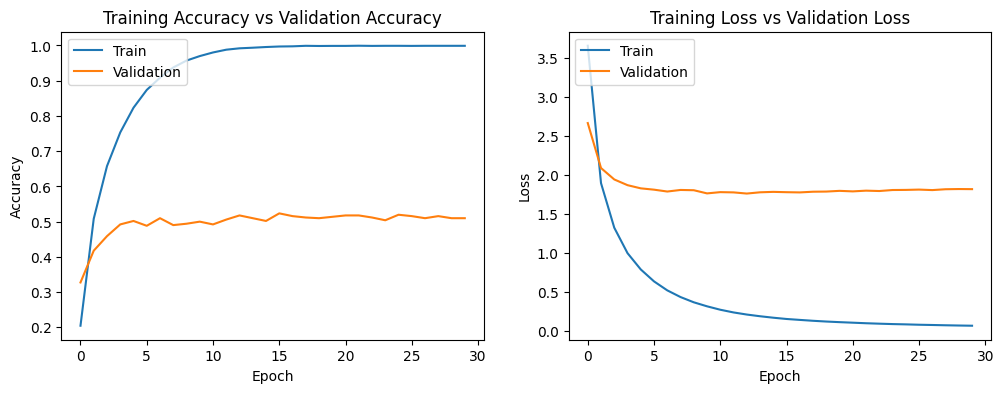

In [9]:
# Plots accuracy and loss plots
evaluate_plots(history)

Evaluate on test data

In [10]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using weighted as the full dataset mbalanced is currently not addressed)
recall = recall_score(y_true, y_pred_classes, average='weighted')        # Recall
f1 = f1_score(y_true, y_pred_classes, average='weighted')                # F1 score

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

16/16 [==============================] - 1s 60ms/step
Test Accuracy: 0.5255
Test Loss: 1.8804
Recall: 0.0157
F1 Score: 0.0136


Check class balance

In [10]:
df['label'].value_counts()

label
Maltese_dog           63
Afghan_hound          59
Scottish_deerhound    58
Samoyed               54
Irish_wolfhound       54
                      ..
malinois              37
boxer                 37
Appenzeller           37
Doberman              37
clumber               37
Name: count, Length: 120, dtype: int64

### <b>Model Setup Issues:</b> 
- The model serverely overfits the data
- The classes are imbalanced
- The loss diverge after epoch 10(1.725, then goes up from there)

### <b>Prioritization:</b> Loss Plateau
We prioritizethe <b>loss plateau</b> We prioritize the loss plateau because it indicates the model has stopped learning effectively, signaling that learning rate is not optimal for further progress, requiring adjustment to enable continous learning before adressing other problems.

### <b>Analysis:</b> Potential Causes
- <b>Too high learning rate (convergence):</b> The model overshoots minima, causing an increasing loss towards the end.
- <b>Fixed learning rate:</b> Without decay, SGD cannot fine-tune weights once the optimal region is reached.
- <b>Insufficient gradient magnitude:</b> Gradients become too small for fixed step sizes, preventing further loss reduction.

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Lower learning rate:</b> Reducing the initial learning rate will minimize overshooting near convergence, leading to smoother optimization and a more stable final loss.
- <b>2. Adaptive optimizers:</b> Switching from fixed SGD optimizer to an adaptive variant (e.g., SGD with momentum or Adam) will help maintain effective gradient scaling, enabling continued progress after the plateau. However, fine-tuning a SGD will likely provide better generalzation for the full dataset, if possible.
- <b>3. Apply LR schedule:</b> Using a learning rate scheduler (e.g., LronPlateue, step decay, cosine decay,  or exponential decay) will allow SGD to take smaller, but more precise steps after the plateau.

## Model Experiment 1: Optimise Learning Rate using a Scheduler
### Hypothesis 3: Apply LR scheduler

### Build model

In [12]:
# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in model.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=3,       
    min_lr=1e-6, 
    verbose=1
)

In [14]:
# Train baseline model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[lr_plateau]

)

Epoch 1/30
128/128 [==============================] - 12s 77ms/step - loss: 3.6699 - accuracy: 0.1819 - val_loss: 2.5743 - val_accuracy: 0.3588 - lr: 0.0300
Epoch 2/30
128/128 [==============================] - 9s 71ms/step - loss: 1.8875 - accuracy: 0.5091 - val_loss: 2.1094 - val_accuracy: 0.4431 - lr: 0.0300
Epoch 3/30
128/128 [==============================] - 9s 72ms/step - loss: 1.3111 - accuracy: 0.6576 - val_loss: 1.9725 - val_accuracy: 0.4529 - lr: 0.0300
Epoch 4/30
128/128 [==============================] - 9s 72ms/step - loss: 0.9939 - accuracy: 0.7566 - val_loss: 1.8571 - val_accuracy: 0.4863 - lr: 0.0300
Epoch 5/30
128/128 [==============================] - 9s 71ms/step - loss: 0.7897 - accuracy: 0.8162 - val_loss: 1.8938 - val_accuracy: 0.4824 - lr: 0.0300
Epoch 6/30
128/128 [==============================] - 9s 71ms/step - loss: 0.6368 - accuracy: 0.8699 - val_loss: 1.8216 - val_accuracy: 0.4863 - lr: 0.0300
Epoch 7/30
128/128 [==============================] - 9s 71ms/s

### <b>Evaluation:</b> Identify issues with the current setup

Plot accuracy and loss curves

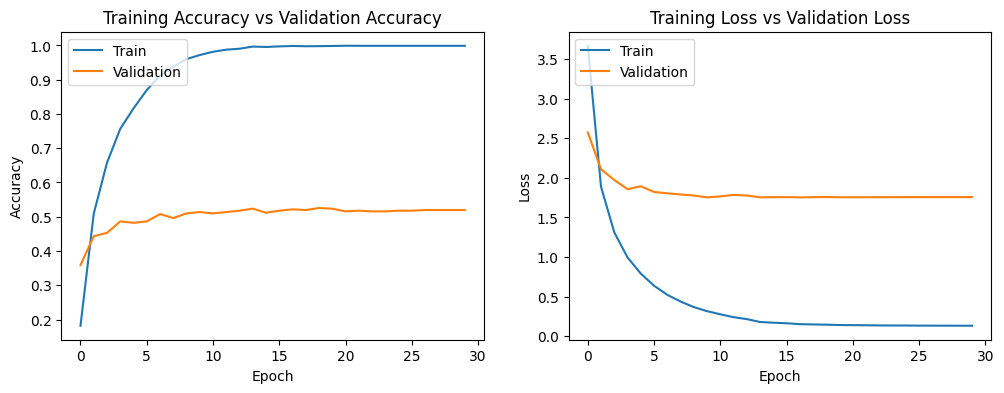

In [15]:
# Plots accuracy and loss plots
evaluate_plots(history)

### <b>Experiment Results:</b> 
- Reducing the learning rate with a LRonPlateau scheduler mitigates the previuous observed loss divergence during training, i.e., the validation loss does not increase from the 7th epoch and onward, laying a better foundation for further improvements.

### <b>Model Setup Issues:</b> 
- The model serverely overfits the data
- The classes are imbalanced
- The validation loss is high (and plateaus)
- We only train on a subset (25%) of the full dataset.

### <b>Prioritization:</b> Overfitting
We prioritize <b>reducing overfitting</b> because the current experiment uses only a small subset of the data, making imbalance effects less significant; class imbalance will be addressed later when using the full dataset (if it still occurs)

### <b>Analysis:</b> Potential Causes
- <b>Limited samples per class:</b> Small training subset only containing 25% (5k) of the data results in few samples per class (~40) potentially increasing model memorization.
- <b>High model capacity:</b> A ResNet50 with a very simple dense decoder can easily overfit limited data (even more likely given the fine-grained and visually similarity nature of the dog breeds: e.g., very subtle difference distinguish a toy poddle from a miniature poodle). The current setup does no mechanism to prevent neuron co-adaptatio (regularization).
- <b>No data augmentation:</b> No transformations to the training images might fail to cover the very subtle intra-class variation (e.g., toy poddle/miniature poodle or eskimo dog/siberian husky). Meaning that for fine-grained classification tasks such as this, increases the model's risk of fitting noise.

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Regularization techniques:</b> Apply weight regularization or dropout in combination with a new non-linear hidden layer to mitigate overfitting (prevent the model memorizing the training data by control the models reliance on specific neurons or large weights were the overfitting likely occurs)
- <b>2. Implement data augmentatin:</b> Add more image data variability so that the model learns general features instead of noise (and syntethically increase the training data size)
- <b>3. Reduce decoder complexity:</b> Reduce the no. of learning parameters in the decoder to prevent overfitting.
- <b>4. Increase training data:</b> Use larger subset of the data to increase the sample diversitu.

# Phase 2: Mitigating Overfitting

## Model Experiment 2: Mitigate Overfitting using Regularization 
### Hypothesis 1: Regularization techniques

References:
</br>
https://www.researchgate.net/publication/366692346_Combining_Regularization_and_Dropout_Techniques_for_Deep_Convolutional_Neural_Network
</br>
https://ieeexplore.ieee.org/document/7877209
</br>
https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

### Build Model

In [16]:
# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in model.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Hidden layer with regularization to mitigate overfitting
#x = Dense(512, activation=None, kernel_regularizer=regularizers.l2(0.001))(x)                   # Non-linear transformation 512 dimension (new hidden layer): L2
#x = Dense(512, activation=None, kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.001))(x)  # Non-linear transformation 512 dimension (new hidden layer): EN regularization
x = Dense(512, activation="relu")(x)          # Non-linear transformation 512 dimension (new hidden layer)
x = Dropout(0.6)(x)                           # 1st dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# Train baseline model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[lr_plateau]

)

Epoch 1/50
128/128 [==============================] - 11s 75ms/step - loss: 4.6279 - accuracy: 0.0534 - val_loss: 3.8302 - val_accuracy: 0.1980 - lr: 0.0300
Epoch 2/50
128/128 [==============================] - 9s 70ms/step - loss: 3.6110 - accuracy: 0.1745 - val_loss: 2.8216 - val_accuracy: 0.3392 - lr: 0.0300
Epoch 3/50
128/128 [==============================] - 9s 70ms/step - loss: 2.8614 - accuracy: 0.2870 - val_loss: 2.3112 - val_accuracy: 0.4216 - lr: 0.0300
Epoch 4/50
128/128 [==============================] - 9s 70ms/step - loss: 2.4403 - accuracy: 0.3652 - val_loss: 2.1014 - val_accuracy: 0.4529 - lr: 0.0300
Epoch 5/50
128/128 [==============================] - 9s 70ms/step - loss: 2.0645 - accuracy: 0.4395 - val_loss: 1.9479 - val_accuracy: 0.4706 - lr: 0.0300
Epoch 6/50
128/128 [==============================] - 9s 70ms/step - loss: 1.9247 - accuracy: 0.4686 - val_loss: 1.8497 - val_accuracy: 0.4804 - lr: 0.0300
Epoch 7/50
128/128 [==============================] - 9s 70ms/s

## <b>Evaluation:</b> Identify issues with the current setup

Plot accuracy and loss curves

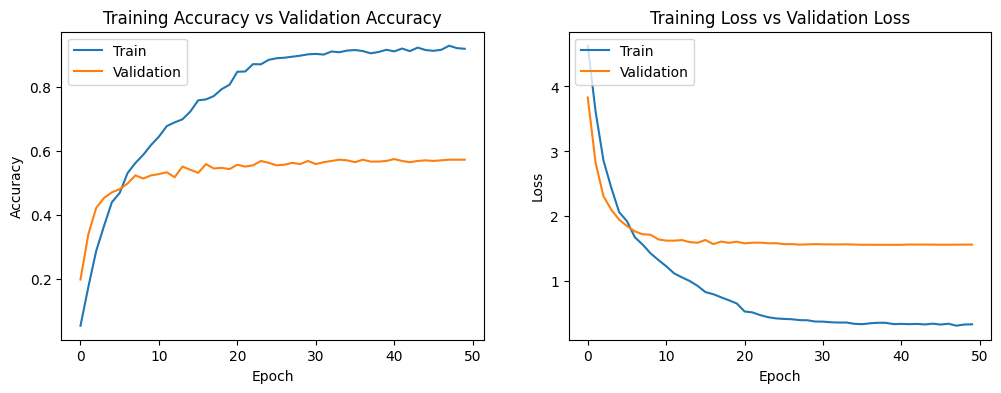

In [18]:
# Plots accuracy and loss plots
evaluate_plots(history)

### <b>Experiment Results:</b> 
- Overfitting is only slightly mitigated (accuracy gap: ~37 now vs. ~48 before): Servere overfitting still occurs.
- Dropout with a hidden layers alone worked better than weight decay (L2), sparsification (L1), Elastic Net (L1 & L2), or a combination both kernel regularization and randomly disabling neurons during training (dropout).
- Overfitting is slightly mitigated, but only because the models validation accuracy increases; the model still memorizes all the training data at some point. Furhter Increasing the droput value doesn’t fix the root cause, but lowers the validations accuracy.

### <b>Model Setup Issues:</b> Same issues observed as with the baseline model
- The model still serverely overfits the data

#### Existing Setup Issues:
- The classes are imbalanced
- The validation loss is high
- We only train on a subset (25%) of the full dataset.
- Model training and convergence is very slow 

### <b>Analysis:</b> Potential Causes
- <b>Too high dropout:</b> The large dropout rate disrupts learning. The model still memorized patterns from the limited subset, showing that excessive dropout alone was insufficient to control overfitting. 

### <b>Prioritization:</b> Overfitting
We again prioritize <b>reducing overfitting</b> because the current experiment uses only a small subset of the data, making imbalance effects less significant; class imbalance will be addressed later when using the full dataset (if it still occurs)

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Distribute dropout across layer:</b> Reducing the dropout rate in the 1st. layer and adding a 2nd. hidden layer with moderate dropout improved the model’s representational capacity, leading to more stable training and reduced overfitting.

# Model Experiment 3: Mitigate Overfitting with Added Hidden Layer and Optimized Dropout
### Hypothesis 1: Distribute dropout across layer

### Build Model

In [19]:
# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in model.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
x = Dense(512, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.5)(x)                           # 1st dropout to random disable neurons during traing to combat overfitting

# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
x = Dense(256, activation="relu")(x)           # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.4)(x)                           # 2nd dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# Train baseline model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=70,
    callbacks=[lr_plateau]
)

Epoch 1/70
128/128 [==============================] - 12s 76ms/step - loss: 4.8237 - accuracy: 0.0189 - val_loss: 4.4518 - val_accuracy: 0.1000 - lr: 0.0300
Epoch 2/70
128/128 [==============================] - 9s 71ms/step - loss: 4.3521 - accuracy: 0.0654 - val_loss: 3.7539 - val_accuracy: 0.1961 - lr: 0.0300
Epoch 3/70
128/128 [==============================] - 9s 71ms/step - loss: 3.7644 - accuracy: 0.1279 - val_loss: 3.0138 - val_accuracy: 0.3118 - lr: 0.0300
Epoch 4/70
128/128 [==============================] - 9s 71ms/step - loss: 3.2526 - accuracy: 0.1941 - val_loss: 2.6145 - val_accuracy: 0.3529 - lr: 0.0300
Epoch 5/70
128/128 [==============================] - 9s 71ms/step - loss: 2.8693 - accuracy: 0.2645 - val_loss: 2.3703 - val_accuracy: 0.3765 - lr: 0.0300
Epoch 6/70
128/128 [==============================] - 9s 71ms/step - loss: 2.6523 - accuracy: 0.2956 - val_loss: 2.1483 - val_accuracy: 0.4235 - lr: 0.0300
Epoch 7/70
128/128 [==============================] - 9s 71ms/s

## <b>Evaluation:</b> Identify issues with the current setup

Plot accuracy and loss curves

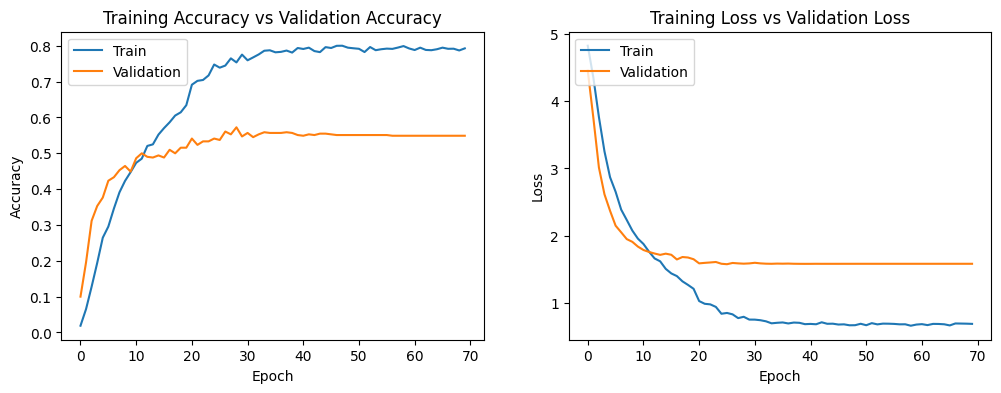

In [21]:
# Plots accuracy and loss plots
evaluate_plots(history)

Check model generalization using the unseen test data

In [22]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using weighted as the full dataset mbalanced is currently not addressed)
recall = recall_score(y_true, y_pred_classes, average='weighted')        # Recall
f1 = f1_score(y_true, y_pred_classes, average='weighted')                # F1 score

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

16/16 [==============================] - 1s 59ms/step
Test Accuracy: 0.5314
Test Loss: 1.7279
Recall: 0.0118
F1 Score: 0.0099


### <b>Experiment Results:</b> 
- Overfitting was again only very slightly mitigated (~24 [now] vs. ~37 [exp 2]: However, servere overfitting still occurs. Overfitting is improved by deepening the archicture and applying dropout, however it does still occur and increasing the dropout impacts the validation accuracy.

##### <b> Test results on unseen data:</b> 
Accuracy (0.53): Suggests that the model guesses common classes correctly. </br>
Recall (0.0137) & F1 (0.0127): Indicates taht it misses most true classes, likely predicting only a few predominant ones.</br>
Loss (1.77): Poor generalizatin and very high confidence in wrong predictions.</br>
Overall the current model setup is biased toward few classes and can not distinguishing between the dog breeds.

### <b>Model Setup Issues:</b> 
- Servere overfitting is not mitigated by deepining and applying dropout (or kernel regularization).
- The model generalization is really bad.
  
#### Existing Setup Issues:
- The classes are imbalanced
- The loss is high
- We only train on a subset (25%) of the full dataset.

### <b>Prioritization:</b> Generalization
We prioritize <b>improving generalization</b> because the model performs well on training data but fails to maintain accuracy on unseen test data, suggesting that our overfitting mitigation efforts may be limited by the available data, by addressing generalization we also reduce the overfitting issue.

### <b>Analysis:</b> Potential Causes
- <b>Limited data availability:</b> The model is trained on too few samples, restricting its ability to learn generalizable patterns and increasing overfitting risk.
- <b>Limited samples per class:</b> Small training subset only containing 25% (5k) of the data results in few samples per class (~40) potentially increasing model memorization.
- <b>No data augmentation:</b> No transformations to the training images might fail to cover the very subtle intra-class variation (e.g., toy poddle/miniature poodle or eskimo dog/siberian husky). Meaning that for fine-grained classification tasks such as this, increases the model's risk of fitting noise.

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Increase training data:</b> Use larger subset of the data to increase the sample diversity: improve the models ability to learn generalizable patterns.
- <b>2. Implement data augmentatin:</b> Add more image data variability so that the model learns general features instead of noise (and syntethically increase the training data size). Data augmentation (e.g., random flips, rotations, bightsness, etc.) will enable the model to better learn intra-class variability, potentially improving generalization for fine-grained details.
- <b>3. Reduce decoder complexity:</b> Reduce the no. of learning parameters in the decoder to prevent overfitting.


#### <b> Hypothesis chosen</b>: 2
We choose hypothesis two as using a larger subset at this stage will increase training time before we have settled on an model architecture and reducing the decoder complexity is a direct conflict with the findinds of experiment 3. Therefore we chose to implement data augmentations to increate variability of the data to the models generalization and hence further mitigating overfitting. 

# Phase 3: Increase Data Diversity

## Model Experiment 4: Improve Generalization with Data Augmentations
### Hypothesis 2: Implement Data Augmentation to increase data availability (syntethically) and diversity to improve generalization.

### Data Augmentations

In [23]:
# Image generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised using preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)

Found 4116 validated image filenames belonging to 29 classes.
Found 514 validated image filenames belonging to 29 classes.
Found 515 validated image filenames belonging to 29 classes.


### Build Model

In [24]:
# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in model.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
x = Dense(512, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.5)(x)                           # 1st dropout to random disable neurons during traing to combat overfitting

# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
x = Dense(256, activation="relu")(x)           # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.4)(x)                           # 2nd dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Train baseline model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=70,
    callbacks=[lr_plateau]
)

Epoch 1/70
128/128 [==============================] - 27s 198ms/step - loss: 4.7502 - accuracy: 0.0282 - val_loss: 4.1383 - val_accuracy: 0.1882 - lr: 0.0300
Epoch 2/70
128/128 [==============================] - 25s 191ms/step - loss: 4.0088 - accuracy: 0.1159 - val_loss: 2.7924 - val_accuracy: 0.4431 - lr: 0.0300
Epoch 3/70
128/128 [==============================] - 25s 193ms/step - loss: 3.0378 - accuracy: 0.2566 - val_loss: 1.7725 - val_accuracy: 0.5765 - lr: 0.0300
Epoch 4/70
128/128 [==============================] - 25s 194ms/step - loss: 2.4223 - accuracy: 0.3517 - val_loss: 1.3603 - val_accuracy: 0.6294 - lr: 0.0300
Epoch 5/70
128/128 [==============================] - 25s 193ms/step - loss: 2.0481 - accuracy: 0.4316 - val_loss: 1.1525 - val_accuracy: 0.6529 - lr: 0.0300
Epoch 6/70
128/128 [==============================] - 25s 194ms/step - loss: 1.8522 - accuracy: 0.4789 - val_loss: 1.0580 - val_accuracy: 0.6745 - lr: 0.0300
Epoch 7/70
128/128 [==============================] 

### <b>Evaluation:</b> Identify issues with the current setup

Plot accuracy and loss curves

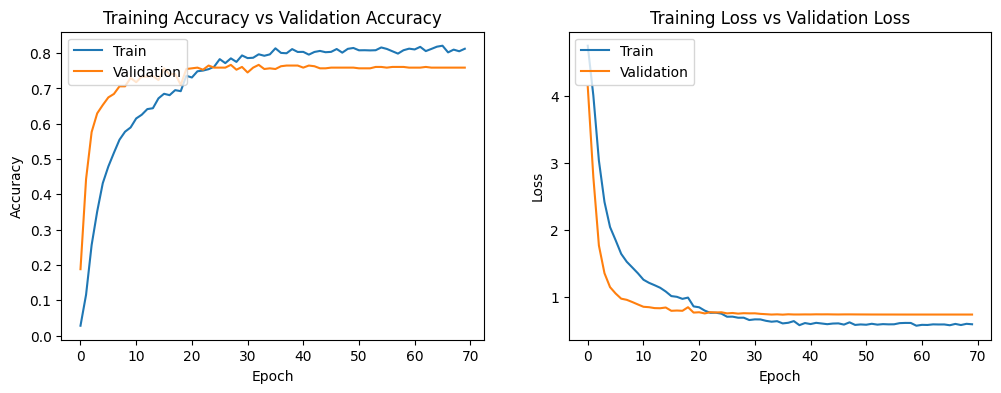

In [26]:
# Plots accuracy and loss plots
evaluate_plots(history)

Check model generalization using the unseen test data

In [27]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using weighted as the full dataset mbalanced is currently not addressed)
recall = recall_score(y_true, y_pred_classes, average='weighted')        # Recall
f1 = f1_score(y_true, y_pred_classes, average='weighted')                # F1 score

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

16/16 [==============================] - 2s 65ms/step
Test Accuracy: 0.7549
Test Loss: 0.8941
Recall: 0.7549
F1 Score: 0.7458


### <b>Experiment Results:</b> 
- The model performance improved significantly improved. The addition of data augmentations results in a large validation accuracy improvement (~ 78 [now] vs. ~ 56 [before]). Similarly the validation loss is also significantly improved (~0. [now] vs. ~1.8 [before])
- The model generalizes a lot better to unseen test data (results below). The very poor generalization observed in prevous experiment is mitigated.
- Because of the large increase in generalization (in combination with the distributed dropout across layers) the overfitting is almost entirely mitigated.

##### <b> Test results on unseen data:</b> 
Accuracy (0.7431): Suggests that the model correctly predicts most samples overall.</br>
Recall (0.7431) & F1 (0.7357): Indicates a balanced performance across classes, with both precision and recall contributing similarly </br>
Loss (0.8824): </br> Which is slightly high, suggesting that while predictions are mostly correct, the model lacks confidence and can still improve generalization, particularly for misclassified dog breeds.

### <b>Model Setup Issues:</b> 
- Low recall and F1 score indicate further class prediction overlap (dog breed misclassifications); very likely because visual features between breeds overlap too much.

#### Existing Setup Issues:
- The classes are imbalanced
- We only train on a subset (25%) of the full dataset.

### <b>Prioritization:</b> Misclassifications
We prioritize to try to mitigate the <b>dog breed misclassifications</b> because before we can improve the model further we need to have a deeper understanding of why and where this occurs.

### <b>Analysis:</b> Potential Causes
- <b>Limited samples per class:</b> Small training subset only containing 25% (5k) of the data results in few samples per class (~40) potentially limiting the models ability to seperate misclassified classes. 
- <b>Limited knowledge of dataset:</b> We currently have very little knowledge about the dataset other than manually inspecting dog breed images in the local directories, in terms of why and where the misclassifcaiton occurs; we have none.
- <b>Dog breed imbalance:</b> There is currently a dog breed class imbalance, which might favour 

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Balance the subset:</b> Balancing the subsample to ensure we have enough samples for each to address the misclassifications. 
- <b>2. Train on full dataset:</b> Train the model on the full dataset to see if more data further improves the model. Also allow us to inspect for which dog breeds the misclassification occur and why. 

#### <b> Hypothesis chosen</b>: 2
While balancing would make a lot sense for the full dataset, for the sample the impact is likely to be a lot lower. Training the model on the entire dataset and do analysis to detect for which dog breeds it fails and why it typically occurs seems like the most appropiate choice to address the misclassifcaiton issues identified.

## Model Experiment 5: Train on Full Dataset
### Hypothesis 2: Training model on full dataset to see if more data improves the model furhter. Also, with the full dataset we can identify misclassified and overlapping classes

### Load, split, and integrate data augmentations for the full dataset

In [31]:
# Directory path of Stanford dataset images
ds_path = 'data/Images'  #unbalanced

# Initialize lists for image path and label
imgs = []
breeds = []

# Iterate image directory and store image path and breed
for folder in os.listdir(ds_path):
    folder_path = os.path.join(ds_path, folder)
    if os.path.isdir(folder_path):
        breed = folder_path.split('-')[1]
        
        # Iterate all imgs in the folder and append to lists
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                imgs.append(os.path.join(folder_path, img_file))
                breeds.append(breed)

# Create the dataframe
df = pd.DataFrame({
    "file": imgs,
    "label": breeds
})

# Split (80/20): Larger training split due to using entire dataset: using stratification on y to preserve proportions
df_train, df_val_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split test and val (50/50): using stratification on y to preserve proportions
df_val, df_test = train_test_split(
    df_val_test,
    test_size=0.5,
    stratify=df_val_test['label'],
    random_state=42
)

# Image generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised using preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


### Build Model (re-initialize previous best model [exp 4])

In [32]:
# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in model.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
x = Dense(512, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.5)(x)                           # 1st dropout to random disable neurons during traing to combat overfitting

# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
x = Dense(256, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.4)(x)                           # 2nd dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
# Train baseline model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=70,
    callbacks=[lr_plateau]
)

Epoch 1/70
515/515 [==============================] - 104s 198ms/step - loss: 3.6194 - accuracy: 0.1749 - val_loss: 1.4555 - val_accuracy: 0.6040 - lr: 0.0300
Epoch 2/70
515/515 [==============================] - 99s 192ms/step - loss: 1.9683 - accuracy: 0.4457 - val_loss: 1.0173 - val_accuracy: 0.6929 - lr: 0.0300
Epoch 3/70
515/515 [==============================] - 99s 192ms/step - loss: 1.5839 - accuracy: 0.5364 - val_loss: 0.8946 - val_accuracy: 0.7221 - lr: 0.0300
Epoch 4/70
515/515 [==============================] - 99s 192ms/step - loss: 1.4154 - accuracy: 0.5795 - val_loss: 0.8621 - val_accuracy: 0.7264 - lr: 0.0300
Epoch 5/70
515/515 [==============================] - 99s 191ms/step - loss: 1.2975 - accuracy: 0.6129 - val_loss: 0.8496 - val_accuracy: 0.7386 - lr: 0.0300
Epoch 6/70
515/515 [==============================] - 99s 193ms/step - loss: 1.2332 - accuracy: 0.6301 - val_loss: 0.7814 - val_accuracy: 0.7590 - lr: 0.0300
Epoch 7/70
515/515 [==============================]

### <b>Evaluation:</b> Identify issues with the current setup

Plot accuracy and loss curves

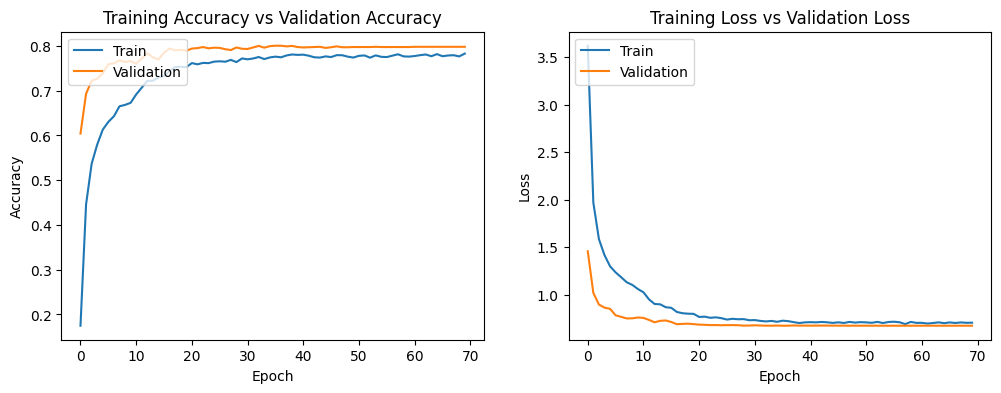

In [34]:
# Plots accuracy and loss plots
evaluate_plots(history)

### <b>Identify misclassifications overlaps and weak classes (the where) and the cause (the why) </b>

Classification Report

In [69]:
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

                                precision    recall  f1-score   support

                  Afghan_hound       0.91      0.88      0.89        24
           African_hunting_dog       0.85      1.00      0.92        17
                      Airedale       1.00      0.70      0.82        20
American_Staffordshire_terrier       0.65      0.76      0.70        17
                   Appenzeller       0.89      0.53      0.67        15
            Australian_terrier       0.71      0.60      0.65        20
            Bedlington_terrier       0.82      1.00      0.90        18
          Bernese_mountain_dog       0.96      1.00      0.98        22
              Blenheim_spaniel       0.94      0.79      0.86        19
                 Border_collie       0.67      0.93      0.78        15
                Border_terrier       0.88      0.88      0.88        17
                   Boston_bull       0.89      0.89      0.89        18
          Bouvier_des_Flandres       0.80      0.80      0.80  

Identify misclassified classes

In [39]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using weighted as the full dataset mbalanced is currently not addressed)
recall = recall_score(y_true, y_pred_classes, average='weighted')        # Recall
f1 = f1_score(y_true, y_pred_classes, average='weighted')                # F1 score

# Arrange by dog breed with struggles
class_report_1 = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)  # classificaiotn report as dict

# Convert to dataframe (trnapose and sort)
class_report_df_1 = pd.DataFrame(class_report_1).transpose()  #transpose
class_report_df_1= class_report_df_1.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore") #drop aggregated rows
class_report_df_1 = class_report_df_1.sort_values(by="f1-score", ascending=True) # arrange by f1

# Filter class df to get classes where the model struggles. We focues on the worst classes, as the good classes are very unlikely to have noticeable overlaps with these given their high accurecy
class_issues_df_1 = class_report_df_1[(class_report_df_1['f1-score'] <= 0.70)]
class_issues_df_1

65/65 [==============================] - 4s 59ms/step


precision    recall  f1-score  support
Eskimo_dog            0.400000  0.266667  0.320000     15.0
miniature_poodle      0.400000  0.266667  0.320000     15.0
Walker_hound          0.428571  0.375000  0.400000     16.0
collie                0.750000  0.375000  0.500000     16.0
toy_poodle            0.636364  0.466667  0.538462     15.0
whippet               0.521739  0.631579  0.571429     19.0
standard_schnauzer    0.777778  0.466667  0.583333     15.0
Rhodesian_ridgeback   0.588235  0.588235  0.588235     17.0
Lhasa                 0.666667  0.526316  0.588235     19.0
German_shepherd       0.875000  0.466667  0.608696     15.0
briard                0.588235  0.666667  0.625000     15.0
Shih                  0.608696  0.666667  0.636364     21.0
Great_Dane            0.692308  0.600000  0.642857     15.0
standard_poodle       0.611111  0.687500  0.647059     16.0
Australian_terrier    0.705882  0.600000  0.648649     20.0
miniature_schnauzer   0.571429  0.750000  0.648649     16.0
malamute              0.631579  0.666667  0.648649     18.0
Appenzeller           0.888889  0.533333  0.666667     15.0
Italian_greyhound     0.619048  0.722222  0.666667     18.0
Siberian_husky        0.636364  0.700000  0.666667     20.0
English_foxhound      0.600000  0.750000  0.666667     16.0
soft                  0.647059  0.687500  0.666667     16.0
Shetland_sheepdog     0.647059  0.733333  0.687500     15.0
kelpie                0.714286  0.666667  0.689655     15.0
toy_terrier           0.833333  0.588235  0.689655     17.0
golden_retriever      1.000000  0.533333  0.695652     15.0
Irish_wolfhound       0.666667  0.727273  0.695652     22.0
Lakeland_terrier      0.700000  0.700000  0.700000     20.0

We can see that many of the dog breeds we initially identified in the proposal as very likely to have overlaps are present in this list. To better understand the overlaps we need to visualise it.

Confusion matrix: Identify the overlaps

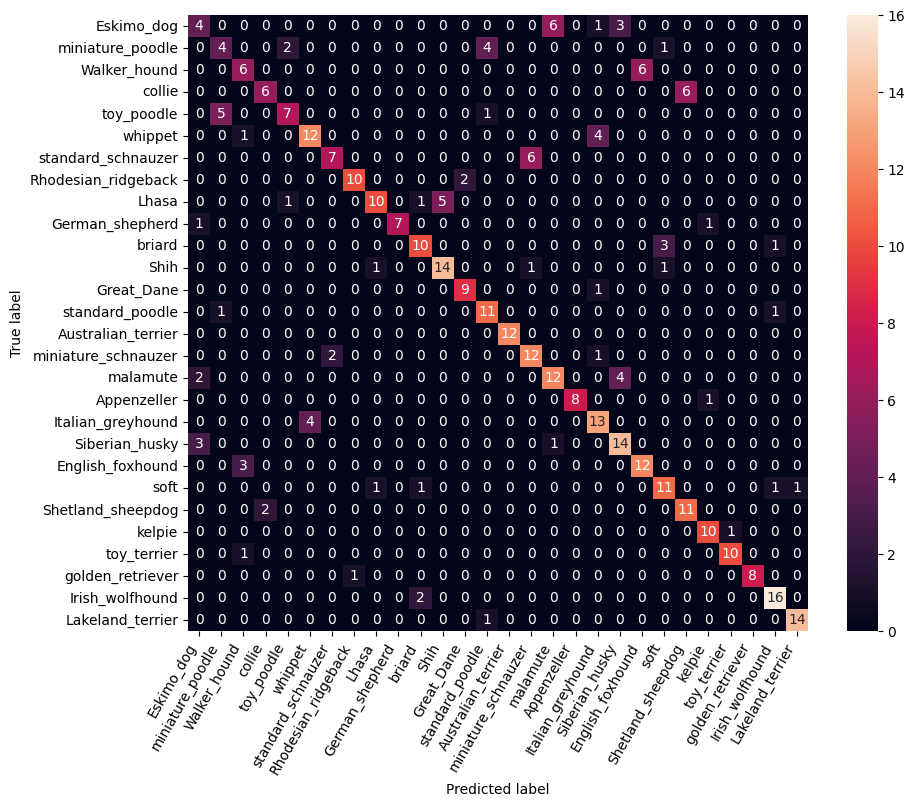

In [40]:
# Get the true classes and their prediction for the dog breed we identified as struggling above: convert to list
class_issues_lst = class_issues_df_1.index.tolist()

# Map class names (breeds) 
breed_name_mapping = {val: breed for breed, val in test_generator.class_indices.items()}

# Apply the class name mapping to ground truth and predictions and convert to pd series
y_true_map = [breed_name_mapping[i] for i in y_true]          # True y mapped
y_true_map = pd.Series(y_true_map)                            # Convert True y mapped to series
y_pred_map = [breed_name_mapping[i] for i in y_pred_classes]  # Predictiomns mapped
y_pred_map = pd.Series(y_pred_map)                            # Convert TPredictiomnsmapped to series

# True lbel os the issue classes (boolean mask)
class_issues_mask = y_true_map.isin(class_issues_lst)

# Applu the class issue mask to filter out dog breeds without issues
y_true_issue = y_true_map[class_issues_mask]  #Exlucde correct predicted breeds
y_pred_issue = y_pred_map[class_issues_mask] # Match samples

# Create dataframe for misclassifcaitons
# Add image file paths
file_paths = pd.Series(test_generator.filepaths)

# Apply class issue mask to filter images for struggling breeds
paths_issue = file_paths[class_issues_mask]

# Create final DataFrame for misclassifications
df_issue_1 = pd.DataFrame({
    "path": paths_issue.values,
    "true": y_true_issue.values,
    "pred": y_pred_issue.values
}).reset_index(drop=True)


# Plot confusion matrix
# Confusion matrix
conf_matrix = confusion_matrix(y_true_issue, y_pred_issue, labels=class_issues_lst)

# Plot the confusion matrix: with this we can inspect all dog breeds overlaps
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=class_issues_lst, yticklabels=class_issues_lst
           )
plt.ylabel('True label')
plt.xticks(rotation=60, ha='right')
plt.xlabel('Predicted label')
plt.show()

#### Predominant overlaps observed:
Eskimo <-> Siberian Husky <-> Malamute<br> 
Toy Poodle <-> Miniature Poodle -> Standard Poodle <br> 
Walker Hound <-> English Foxhound<br> 
Collie <-> Shetland Sheepdog <br> 
Whippet <-> Italian Greyhound<br> 
Standard Schnauzer <-> Miniature Schnauzer

The observations align with the potential issues outlined in the project proposal, in fact some of the identified potential overlaps are present.

### Identify Potential Misclassification Causes

Above we have identified the misclassifications overlaps (the where). Now we need to identify the cause (the why). We do this by manually inspecting the overlapping dog breed images to identify patterns in the underlying data we can address.


In [41]:
# create helper function for plotting them side-sy-side
def misclassed_dogs(df, breed_a, idx_a, breed_b, idx_b):
    # Left: breed_b misclassified as breed_a
    left = df[(df["true"] == breed_b) & (df["pred"] == breed_a)]
    img_left = Image.open(left.iloc[idx_a]["path"]).convert("RGB")

    # Right: breed_a misclassified as breed_b
    right = df[(df["true"] == breed_a) & (df["pred"] == breed_b)]
    img_right = Image.open(right.iloc[idx_b]["path"]).convert("RGB")

    # side by side plot init
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Lft miscalssifed dog breed
    axes[0].imshow(img_left)
    axes[0].set_title(f"True: {breed_b}\nPred: {breed_a}")
    
    # right miscalssifed dog breed
    axes[1].imshow(img_right)
    axes[1].set_title(f"True: {breed_a}\nPred: {breed_b}")

    #plot
    plt.suptitle(f"Misclassifications of: {breed_a} & {breed_b}", fontsize=14) #tiel e
    plt.tight_layout(pad=2)
    plt.show()

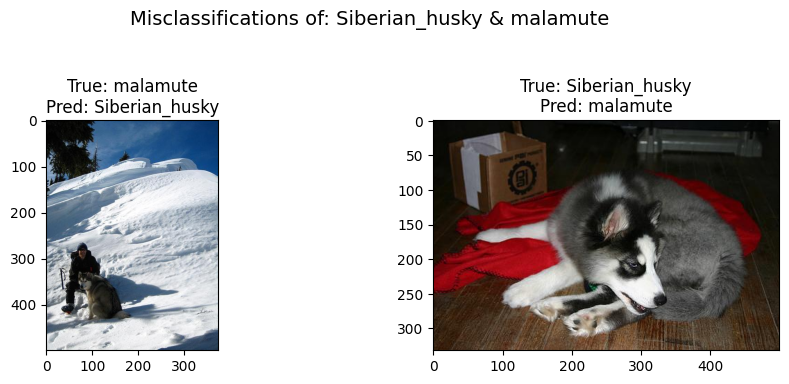

In [42]:
# Siberian_husky and malamute
misclassed_dogs(df_issue_1, "Siberian_husky", 0, "malamute", 0)

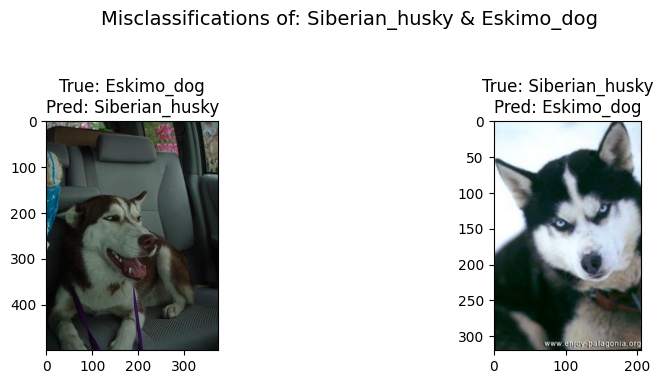

In [54]:
# Siberian_husky and malamute
misclassed_dogs(df_issue_1, "Siberian_husky", 0, "Eskimo_dog", 0)

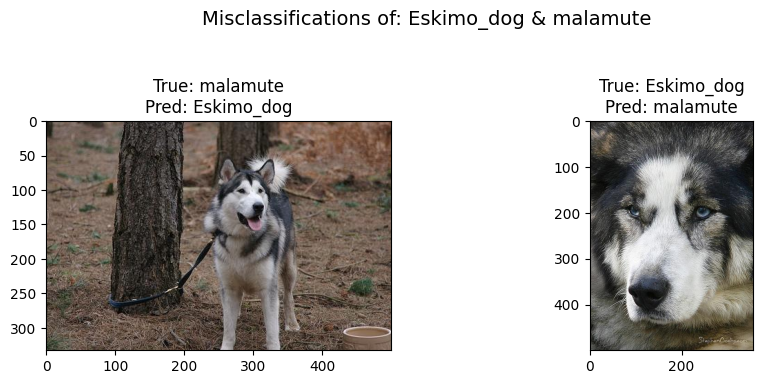

In [56]:
# Siberian_husky and malamute
misclassed_dogs(df_issue_1, "Eskimo_dog", 0, "malamute", 0)

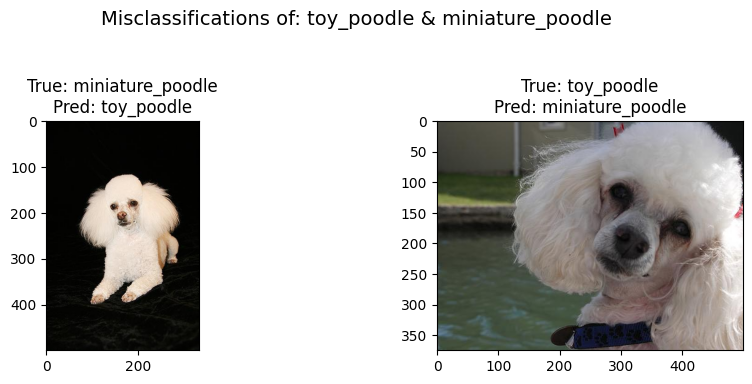

In [43]:
# Eskimo_dog and miniature_poodle
misclassed_dogs(df_issue_1, "toy_poodle", 0, "miniature_poodle", 0)

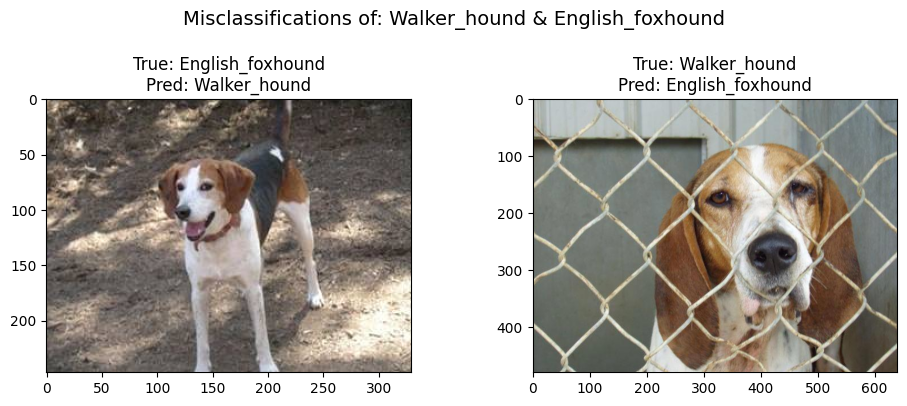

In [44]:
# toy_poodle and miniature_poodle
misclassed_dogs(df_issue_1, "Walker_hound", 0, "English_foxhound", 0)

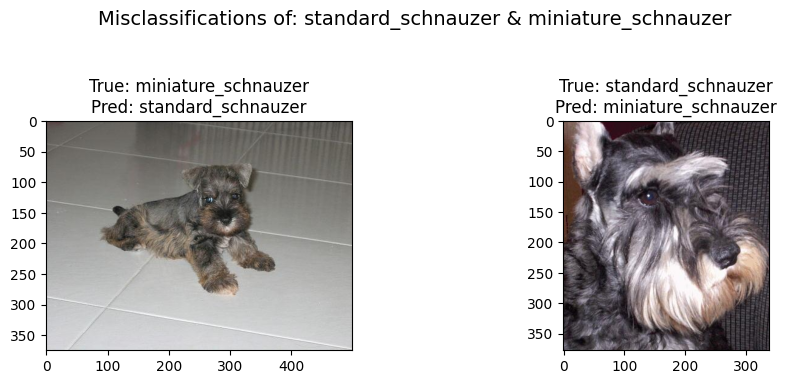

In [49]:
# toy_poodle and miniature_poodle
misclassed_dogs(df_issue_1, "standard_schnauzer", 0, "miniature_schnauzer", 0)

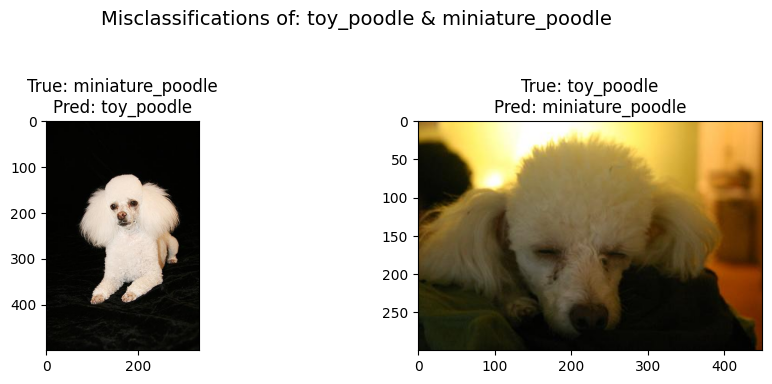

In [66]:
# toy_poodle and miniature_poodle
misclassed_dogs(df_issue_1, "toy_poodle", 0, "miniature_poodle",4)

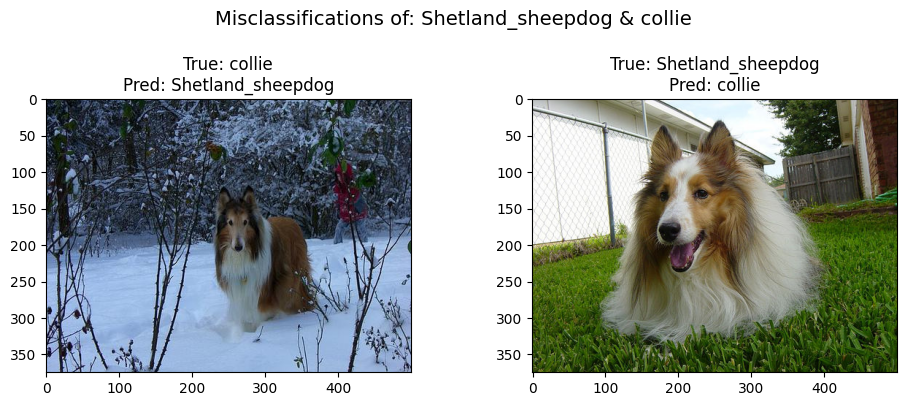

In [50]:
# toy_poodle and miniature_poodle
misclassed_dogs(df_issue_1, "Shetland_sheepdog", 0, "collie", 0)

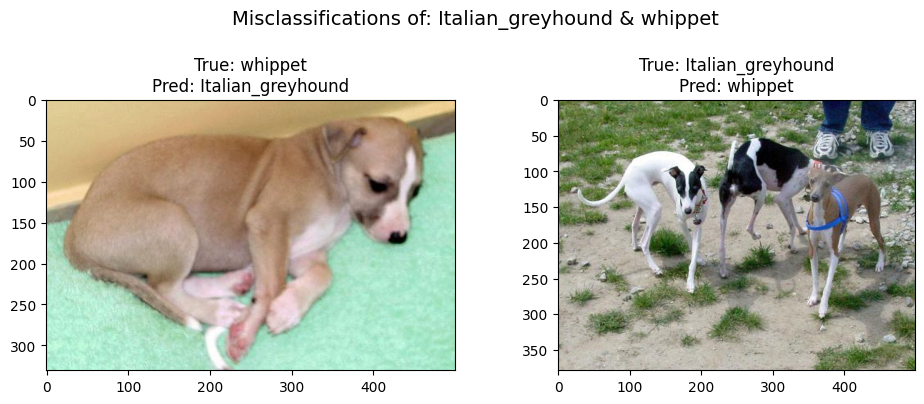

In [51]:
# toy_poodle and miniature_poodle
misclassed_dogs(df_issue_1, "Italian_greyhound", 0, "whippet", 0)


### <b>Experiment Results:</b> 
There is a lot noise in the images! By manually inspecting samples of predominantly miscalssified dogs breeds, it is clear that often these are due to noise in the images, such as multiple dogs, people, dogs that are dressed up or otherwise portraing human actions (playing piano, sitting at chair, etc.) Another vital issue, that might be a bit harder to address, occurs for different dog breeds when they share a hairstyles, observed for toy poodle, poddle, miniature poodles. Some noise that might be hard to mitigate, is that some of the breeds have puppies, whereas others don't.
- The the overlapping dog breeds visualized are just the first images for each of the overlapping misclassifications, the noise described is based on manually inspecting multiple overlaps for the chosen breeds
  
##### <b>Predominant overlaps observed:</b> 
Eskimo <-> Siberian Husky <-> Malamute<br> 
Toy Poodle <-> Miniature Poodle -> Standard Poodle <br> 
Walker Hound <-> English Foxhound<br> 
Collie <-> Shetland Sheepdog <br> 
Whippet <-> Italian Greyhound<br> 
Standard Schnauzer <-> Miniature Schnauzer

### <b>Model Setup Issues:</b> 
- A lot of noise in the underlying data.
- Training time is slow (continous after convergence)
- Slight underfitting seems to occur 

#### Existing Setup Issues:
- The classes are imbalanced

### <b>Prioritization:</b> reducing noise in the underlying data
We prioritize <b>reducing noise in the underlying data</b> as the experiment findinds indicate this as the root cause for the dog breed misclassifications. Furhtermore, slight underfitting occurs, which indicate we need to adjust the dropout rates. Furthermore, we lower the no. of epochs to address <b>slow training time</b> as the model converges faster on the full dataset and adjust the learning rate plateau patience to address the <b>slight underfitting</b>.

### <b>Analysis:</b> Potential Causes
- <b>Multiple dogs in same image:</b> Many misclassified dog breeds are due to multiple dogs in the same image, where the model predicts the wrong dog.
- <b>Very similar features:</b> The model cannot clearly distinct between dog breeds that look a lot a like (e.g., siberian husky and malamute).
- <b>Other types of noise in the images:</b> Other living objects in the images: such as people, cats, etc.
- <b>Dog in unnatural scenery:</b> Dog that perform activities such as playing piano, or dressing up, etc. 
- <b>Dog hairstyles:</b> Different dog breeds that they share the same, human-cut hairstyles, instead of their natural hairstyle.

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Crop images:</b> By cropping the images to a bounding box around the dog we want to predict, we can address the issue with multiple dogs or other animate beings (with facial fetures) in the same images. This could potentially also mitigate some unnatural sceneries. 

# Phase 4: Improve Inter-class Misclassification for Weak Classes

## Model Experiment 6: Reduce Image Data Noise (Distractions in the images: potential causes identified)
### Hypothesis 1: Cropping the images to the target dog's bounding box

</br>
Dog bounding box coordinates annotations are including the in Stanford Dogs Dataset dataset.</br>
Reference:
http://vision.stanford.edu/aditya86/ImageNetDogs/

### Crop image data

In [8]:
# Articles read during literature review with state-of-art performance claims all used cropped version of the images based on the annotations file provided by the dataset creators
# References: 
# https://stackoverflow.com/questions/4722794/parsing-an-xml-file-using-element-tree
# http://vision.stanford.edu/aditya86/ImageNetDogs/
import xml.etree.ElementTree as ET
from PIL import Image

# Directories
images_dir = "data/Images"
annotations_dir = "data/Annotation"
output_dir = "data/Images_crop"

# Check if the directory exsits: if it exists : skip entire block, otherwise crop images based on Stanfords bb annotations provided
if os.path.isdir('data/Images_crop'):
    print("Outout directory already exist!")
else:
    # Create the croppet output directory (if it doesnt exist)
    os.makedirs(output_dir, exist_ok=True)
    for breed in os.listdir(images_dir):
        os.makedirs(os.path.join(output_dir, breed), exist_ok=True)
    
    print("Creating outout directory (if it doesnt exist): This might take a while")
    
    # Iterate image directory and store image path and breed
    for breed in os.listdir(images_dir):
        img_dir = os.path.join(images_dir, breed)
        ann_dir = os.path.join(annotations_dir, breed)
    
        # Read all annotation xml files
        for ann_file in os.listdir(ann_dir):
            base_name, _ = os.path.splitext(ann_file) 
            img_file = base_name + ".jpg"
            img_path = os.path.join(img_dir, img_file)
            if not os.path.exists(img_path):
                continue
    
            # Parse annotation
            tree = ET.parse(os.path.join(ann_dir, ann_file))
            box = tree.getroot().findall("object")[0].find("bndbox")
            xmin, ymin = int(box.find("xmin").text), int(box.find("ymin").text)
            xmax, ymax = int(box.find("xmax").text), int(box.find("ymax").text)
    
            # Crop the iamge based on the annotation coordianates and store it  save
            img = Image.open(img_path).crop((xmin, ymin, xmax, ymax)).convert("RGB")
            out_path = os.path.join(output_dir, breed, img_file)
            img.save(out_path, "JPEG")

Outout directory already exist!


Load, split, and integrate data augmentations for the cropped images of the full dataset

In [9]:
# Directory path of Stanford dataset images cropped based on the XML annotions coordinates
ds_path = "data/Images_crop"

# Initialize lists for image path and label
imgs = []
breeds = []

# Iterate image directory and store image path and breed
for folder in os.listdir(ds_path):
    folder_path = os.path.join(ds_path, folder)
    if os.path.isdir(folder_path):
        breed = folder_path.split('-')[1]
        
        # Iterate all imgs in the folder and append to lists
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                imgs.append(os.path.join(folder_path, img_file))
                breeds.append(breed)

# Create the dataframe
df = pd.DataFrame({
    "file": imgs,
    "label": breeds
})


# Split (80/20): Larger training split due to using entire dataset: using stratification on y to preserve proportions
df_train, df_val_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split test and val (50/50): using stratification on y to preserve proportions
df_val, df_test = train_test_split(
    df_val_test,
    test_size=0.5,
    stratify=df_val_test['label'],
    random_state=42
)

# Image generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised using preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


### Build Model
Training for less epochs are the models trained on the full dataset seem to converge a lot sooner

In [10]:
# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in model.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
x = Dense(512, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.5)(x)                           # 1st dropout to random disable neurons during traing to combat overfitting

# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
x = Dense(256, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.4)(x)                           # 2nd dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=4,       
    min_lr=1e-6, 
    verbose=1
)

In [12]:
# Train baseline model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50, #reduced epochs
    callbacks=[lr_plateau]
)

#model and evaluations re-run because first run evaluated the model using weighted average and not macro as intended.

Epoch 1/50
515/515 [==============================] - 98s 187ms/step - loss: 3.3814 - accuracy: 0.2135 - val_loss: 1.1942 - val_accuracy: 0.6676 - lr: 0.0300
Epoch 2/50
515/515 [==============================] - 97s 188ms/step - loss: 1.7480 - accuracy: 0.4961 - val_loss: 0.8175 - val_accuracy: 0.7478 - lr: 0.0300
Epoch 3/50
515/515 [==============================] - 96s 187ms/step - loss: 1.3976 - accuracy: 0.5842 - val_loss: 0.7058 - val_accuracy: 0.7726 - lr: 0.0300
Epoch 4/50
515/515 [==============================] - 96s 187ms/step - loss: 1.2314 - accuracy: 0.6276 - val_loss: 0.6838 - val_accuracy: 0.7799 - lr: 0.0300
Epoch 5/50
515/515 [==============================] - 97s 187ms/step - loss: 1.1400 - accuracy: 0.6554 - val_loss: 0.6473 - val_accuracy: 0.7891 - lr: 0.0300
Epoch 6/50
515/515 [==============================] - 97s 187ms/step - loss: 1.0578 - accuracy: 0.6731 - val_loss: 0.6255 - val_accuracy: 0.7959 - lr: 0.0300
Epoch 7/50
515/515 [==============================] 

### <b>Evaluation:</b> Identify issues with the current setup

Plot accuracy and loss curves

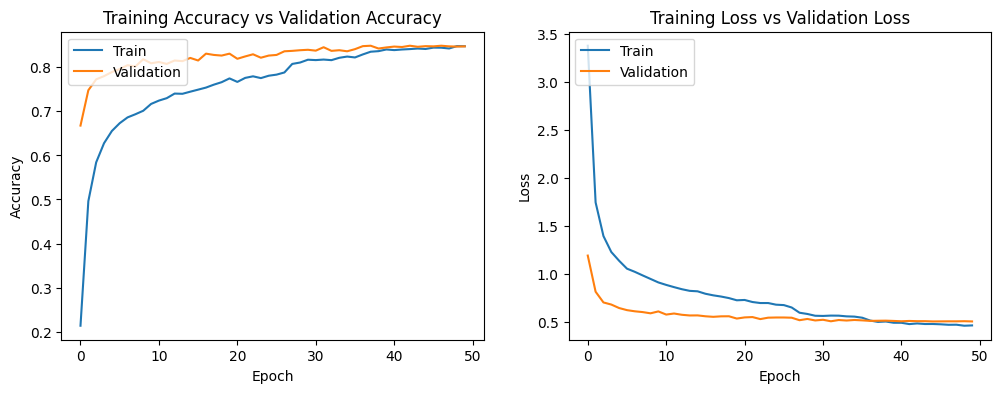

In [13]:
# Plots accuracy and loss plots
evaluate_plots(history)

In [14]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using macro)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

65/65 [==============================] - 4s 58ms/step
Test Accuracy: 0.8523
Test Loss: 0.4848
Recall: 0.8492
F1 Score: 0.8483


Inspect the misclassification overlaps

In [82]:
# Arrange by dog breed with struggles
class_report_2 = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)  # classificaiotn report as dict

# Convert to dataframe (trnapose and sort)
class_report_df_2 = pd.DataFrame(class_report_2).transpose()  #transpose
class_report_df_2= class_report_df_2.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore") #drop aggregated rows
class_report_df_2 = class_report_df_2.sort_values(by="f1-score", ascending=True) # arrange by f1

# Filter class df to get classes where the model struggles. We focues on the worst classes, as the good classes are very unlikely to have noticeable overlaps with these given their high accurecy
class_issues_df_2 = class_report_df_2[(class_report_df_2['f1-score'] <= 0.70)]
class_issues_df_2

65/65 [==============================] - 4s 58ms/step


precision    recall  f1-score  support
Eskimo_dog                  0.400000  0.266667  0.320000     15.0
miniature_poodle            0.500000  0.400000  0.444444     15.0
Appenzeller                 0.750000  0.400000  0.521739     15.0
standard_schnauzer          0.750000  0.400000  0.521739     15.0
toy_poodle                  0.636364  0.466667  0.538462     15.0
Walker_hound                0.555556  0.625000  0.588235     16.0
collie                      0.800000  0.500000  0.615385     16.0
Rhodesian_ridgeback         0.647059  0.647059  0.647059     17.0
Siberian_husky              0.551724  0.800000  0.653061     20.0
Lakeland_terrier            0.684211  0.650000  0.666667     20.0
soft                        0.647059  0.687500  0.666667     16.0
Staffordshire_bullterrier   0.666667  0.666667  0.666667     15.0
toy_terrier                 0.900000  0.529412  0.666667     17.0

In [84]:
print(len(class_issues_df_2))

13


The misclassified breeds decreased from 28 to 13 by reducing the underlying noise in the data by cropping the images to the bounding boxes provided in the annotations.

#### Plotting confusion matrix to inspect the overlaps

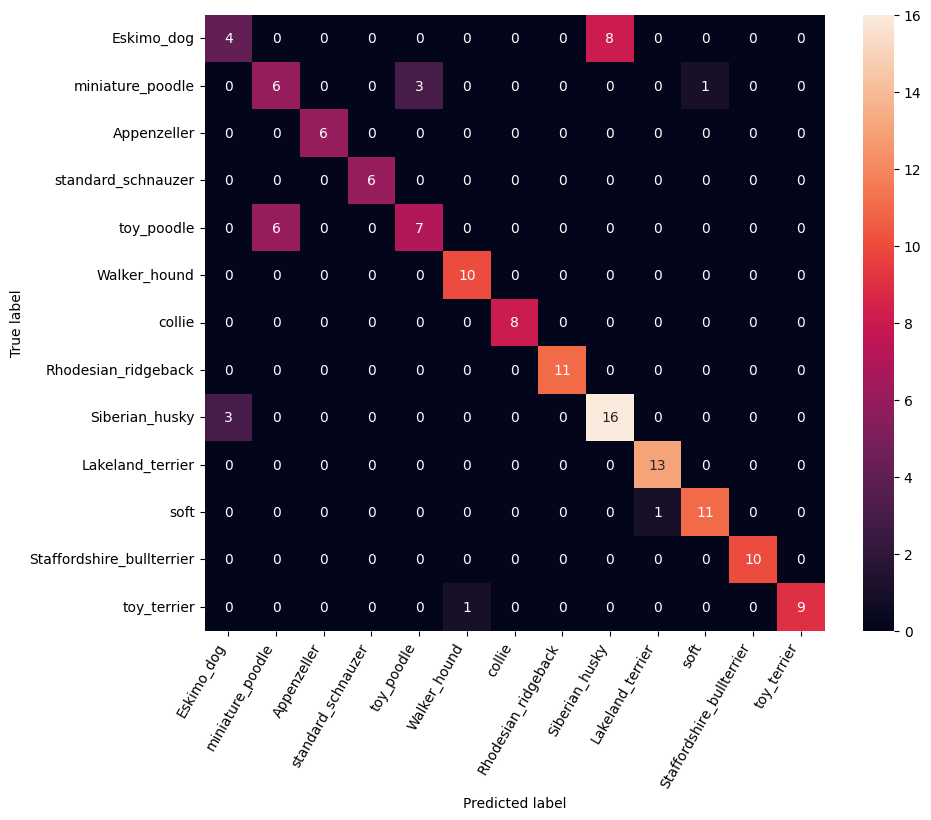

In [85]:
# Get the true classes and their prediction for the dog breed we identified as struggling above: convert to list
class_issues_lst_2 = class_issues_df_2.index.tolist()

# Map class names (breeds) 
breed_name_mapping = {val: breed for breed, val in test_generator.class_indices.items()}

# Apply the class name mapping to ground truth and predictions and convert to pd series
y_true_map = [breed_name_mapping[i] for i in y_true]          # True y mapped
y_true_map = pd.Series(y_true_map)                            # Convert True y mapped to series
y_pred_map = [breed_name_mapping[i] for i in y_pred_classes]  # Predictiomns mapped
y_pred_map = pd.Series(y_pred_map)                            # Convert TPredictiomnsmapped to series

# True lbel os the issue classes (boolean mask)
class_issues_mask = y_true_map.isin(class_issues_lst_2)

# Applu the class issue mask to filter out dog breeds without issues
y_true_issue = y_true_map[class_issues_mask]  #Exlucde correct predicted breeds
y_pred_issue = y_pred_map[class_issues_mask] # Match samples

# Create dataframe for misclassifcaitons
# Add image file paths
file_paths = pd.Series(test_generator.filepaths)

# Apply class issue mask to filter images for struggling breeds
paths_issue = file_paths[class_issues_mask]

# Create final DataFrame for misclassifications
df_issue_2 = pd.DataFrame({
    "path": paths_issue.values,
    "true": y_true_issue.values,
    "pred": y_pred_issue.values
}).reset_index(drop=True)


# Plot confusion matrix
# Confusion matrix
conf_matrix_2 = confusion_matrix(y_true_issue, y_pred_issue, labels=class_issues_lst_2)

# Plot the confusion matrix: with this we can inspect all dog breeds overlaps
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_2, annot=True, fmt='d',
            xticklabels=class_issues_lst_2, yticklabels=class_issues_lst_2
           )
plt.ylabel('True label')
plt.xticks(rotation=60, ha='right')
plt.xlabel('Predicted label')
plt.show()

Inspecting the new confusion matrix, we observe a huge improvement in the no. of misclassified dog breeds (now 13 vs. 28 before). The misclassification overlaps are significantly improved:

##### <b>Predominant overlaps observed:</b> 
Eskimo <-> Siberian Husky : (no longer a overlap with Malamute)  </br>
Toy Poodle <-> Miniature Poodle : (no longer a overlap with Standard Poodle)   <br> 
Walker Hound and English Foxhound does no longer overlap<br> 
Collie and Shetland Sheepdog does no longer overlap<br> 
Whippet and Italian Greyhound does no longer overlap<br> 
Standard Schnauzer and Miniature Schnauzer does no longer overlap

Check class imbalance for the full dataset

In [86]:
df['label'].value_counts()

label
Maltese_dog             252
Afghan_hound            239
Scottish_deerhound      232
Pomeranian              219
Bernese_mountain_dog    218
                       ... 
Irish_water_spaniel     150
affenpinscher           150
Bouvier_des_Flandres    150
Pekinese                149
redbone                 148
Name: count, Length: 120, dtype: int64

### <b>Experiment Results:</b> 
- Cropping the images to the bounding box of the intended dog did significantly improve model performance. The no. dog breeds with servere misclassificatins is heavily reduced. Some of the previous overlaps are mitigated.
- Servere class imbalance for the full dataset (252 for class with most images and 148 for class with fewest)
- The slight underfitting is no longer observed.
- We cannot say with certainty that the model is fully converged when the training concludes, this occurs due to the reduces no. of epochs in combination with increased LRonPlateau patience, furhter experiments could benefit from additional epochs.

##### <b>Overlaps mitigated:</b> 
Eskimo <-> Siberian Husky : (no longer a overlap with Malamute)  </br>
Toy Poodle <-> Miniature Poodle : (no longer a overlap with Standard Poodle)   <br> 
Walker Hound and English Foxhound does no longer overlap<br> 
Collie and Shetland Sheepdog does no longer overlap<br> 
Whippet and Italian Greyhound does no longer overlap<br> 
Standard Schnauzer and Miniature Schnauzer does no longer overlap

##### <b>Remaining overlaps:</b> 
Eskimo <-> Siberian Husky  </br>
Toy Poodle <-> Miniature Poodle </br>

### <b>Model Setup Issues:</b> 
- Misclassification for some dog breeds still occur.
- Model did likely not fully converge.

#### Existing Setup Issues:
- The classes are imbalanced
- Training time is slow (due to 20k images and data augmentations)

### <b>Prioritization:</b> 
We prioritize the <b>class imbalanced</b> because it most likely introduces bias toward majority breeds and thus reducing performance on underrepresented ones. Addressing itensures more balanced training and fairer evaluation across all classes goin forward.

### <b>Analysis:</b> Potential Causes
- <b>Imbalanced classes:</b> The class imbalance likely impacts the model’s performance by biasing predictions toward majority breeds, reducing recall and accuracy for the underrepresented classes. No class weighting mean that the loss favors frequent classes. 

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Implement class weighting:</b> Adjust the loss function to give higher weight to underrepresented breeds, balancing their influence during training. 
- <b>2. Generate syntethic images:</b> Increase the diversity of minority classes, to improve feature learning and reduce bias. Achived by either using ImageDataGenerator to generate synthetic images and store in the underrepresented breeds folders. Alternatively including images from the very simliar Tsinghua Dogs Dataset (https://cg.cs.tsinghua.edu.cn/ThuDogs)

#### <b> Hypothesis chosen</b>: 1
Implementing class weights using keras built-in 'compute_class_weight' funciton is the most straightforward to solution to the issue first, as generating synthetic images with ImageDataGenerator requires more computational power and will result in prolonged training time. Including image data from a similar dataset, while it may be a solution to the issue does invalid the models performance against state-of-art for the orignal dataset.

## Model Experiment 6: Address Class Imbalance
### Hypothesis 1: Use class weights to address the observed class imbalance and increase no. of epochs to ensure model training converge.

In [17]:
# Model checkpoint: Saves the best model from training
model_checkpoint = ModelCheckpoint(
    'models/resnet50.h5',
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

### Compute class weights

In [18]:
# numeric labels from generator
y_train = train_generator.classes

# compute weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# convert to dict for Keras
class_weight_dict = dict(zip(np.unique(y_train), weights))

### Build Model

In [19]:
# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in model.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
x = Dense(512, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.5)(x)                           # 1st dropout to random disable neurons during traing to combat overfitting

# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
x = Dense(256, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.4)(x)                           # 2nd dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# Train baseline model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,  #increased to allow model to converge better
    callbacks=[lr_plateau, model_checkpoint],
    class_weight=class_weight_dict
)
#model and evaluations re-run because first run evaluated the model using weighted average and not macro as intended.

Epoch 1/60
515/515 [==============================] - ETA: 0s - loss: 3.4613 - accuracy: 0.1944
Epoch 1: val_accuracy improved from -inf to 0.66472, saving model to models\resnet50.h5
515/515 [==============================] - 96s 182ms/step - loss: 3.4613 - accuracy: 0.1944 - val_loss: 1.2168 - val_accuracy: 0.6647 - lr: 0.0300
Epoch 2/60
515/515 [==============================] - ETA: 0s - loss: 1.8022 - accuracy: 0.4796
Epoch 2: val_accuracy improved from 0.66472 to 0.73810, saving model to models\resnet50.h5
515/515 [==============================] - 93s 180ms/step - loss: 1.8022 - accuracy: 0.4796 - val_loss: 0.8230 - val_accuracy: 0.7381 - lr: 0.0300
Epoch 3/60
515/515 [==============================] - ETA: 0s - loss: 1.3992 - accuracy: 0.5804
Epoch 3: val_accuracy improved from 0.73810 to 0.77745, saving model to models\resnet50.h5
515/515 [==============================] - 92s 179ms/step - loss: 1.3992 - accuracy: 0.5804 - val_loss: 0.7091 - val_accuracy: 0.7775 - lr: 0.0300
E

## <b>Evaluation:</b> Identify issues with the current setup

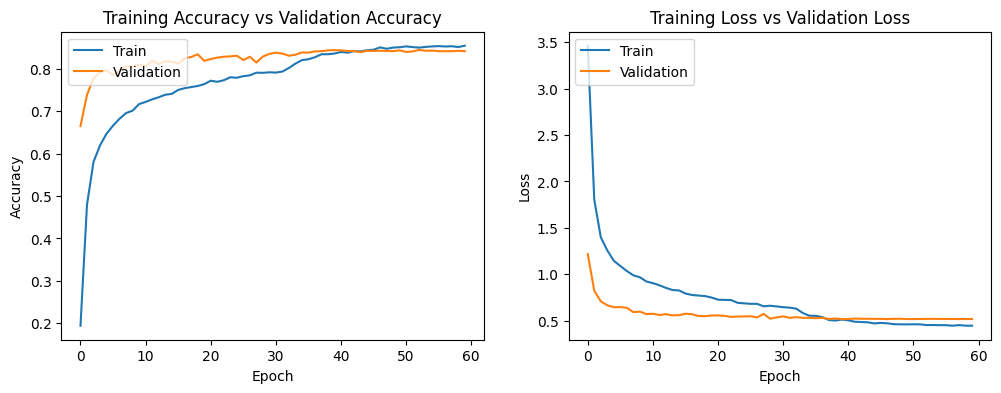

In [21]:
# Plots accuracy and loss plots
evaluate_plots(history)

In [22]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using weighted as the full dataset mbalanced is currently not addressed)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

65/65 [==============================] - 4s 57ms/step
Test Accuracy: 0.8484
Test Loss: 0.4932
Recall: 0.8464
F1 Score: 0.8451


### <b>Experiment Results:</b> 
- Balancing the classes did not have an positive affect on the models generalization on the unseen test data compared (comparison below).
- We did not observe any model improvements in terms of increased validation accuracy or decreased validation loss, i.e., the improvements observed are diminishing, potentially indicating a ceiling for the chosen baseline model(ResNet50).
- Although class weighting did not improve the model, it remains beneficial for ensuring fairer learning across minority classes, preventing the model from relying disproportionately on majority breeds in future experiments.

<b>Imbalanced dataset:</b> </br>
Test Accuracy: 0.8523</br>
Test Loss: 0.4848</br>
Recall: 0.8492</br>
F1 Score: 0.8483</br>

<b>Balanced dataset:</b> </br>
Test Accuracy: 0.8484 </br>
Test Loss: 0.4932 </br>
Recall: 0.8464 </br>
F1 Score: 0.8451  </br>

### <b>Model Setup Issues:</b> 
-  Diminishing model improvements.

#### Existing Setup Issues:
- Misclassification for some dog breeds still occur.
- Training time is slow (due to 20k images and data augmentations)

### <b>Prioritization:</b> Misclassification
We prioritize further <b>reducing misclassificaiton</b> because our previous model evaluation shows that certain breeds, while improved a lot, are sometimes still sometimes misclassified. Directly targeting the few misclassified dog breeds should also have an impact the <b>diminishing model improvements</b> issue.

### <b>Analysis:</b> Potential Causes
- <b>Limited fine-tuning:</b> Keeping the encoder layers frozen prevents adaptation of high-level dog breed features.
- <b>Decoder undercapacity:</b> The decoder potentially cannot effectively refine or separate overlapping feature representations with only 2 layers.
- <b>Pretrained model limitation:</b> While ResNet50 provides strong general representations, it might not be fully capable of capturing more subtle, breed-specific variations needed for further improvement.

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Unfreeze encoder layers:</b> Unfreeze some of the latter layers in the later layers of the encoder to allow fine-tuning to adapt pretrained features for fine-grained breed distinctions to potentially reduce misclassification for the frequently misclassified breeds.
- <b>2. Increase decoder depth :</b> Add additional layers or increase neuron count to enhance the decoder’s capacity to reduce misclassification for the frequently misclassified breeds.

#### <b> Hypothesis chosen</b>: 1.
Unfreezing some of the latter the encoder layers, could potentially allow the pretrained backbone to adapt its features to fine-grained dog breed distinctions resulting in misclasifications due to dog breed appearance overlaps.


## Model Experiment 7: Unfreezen Encoder layer
### Hypothesis 1: Freezing top layers in the encoder to allow fine-tuning to adapt pretrained features for fine-grained breed distinctions to potentially reduce misclassification for the frequently misclassified breeds.


In [3]:
# Directory path of Stanford dataset images cropped based on the XML annotions coordinates
ds_path = "data/Images_crop"

# Initialize lists for image path and label
imgs = []
breeds = []

# Iterate image directory and store image path and breed
for folder in os.listdir(ds_path):
    folder_path = os.path.join(ds_path, folder)
    if os.path.isdir(folder_path):
        breed = folder_path.split('-')[1]
        
        # Iterate all imgs in the folder and append to lists
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                imgs.append(os.path.join(folder_path, img_file))
                breeds.append(breed)

# Create the dataframe
df = pd.DataFrame({
    "file": imgs,
    "label": breeds
})


# Split (80/20): Larger training split due to using entire dataset: using stratification on y to preserve proportions
df_train, df_val_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split test and val (50/50): using stratification on y to preserve proportions
df_val, df_test = train_test_split(
    df_val_test,
    test_size=0.5,
    stratify=df_val_test['label'],
    random_state=42
)

# Image generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised using preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


In [4]:
# numeric labels from generator
y_train = train_generator.classes

# compute weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# convert to dict for Keras
class_weight_dict = dict(zip(np.unique(y_train), weights))

In [5]:

# Encoder: The pretrained model (ResNet50)
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Unfreeze some of the encoder layers
for layer in model.layers[:-3]:
    layer.trainable = False
for layer in model.layers[-3:]:
    layer.trainable = True

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(model.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector

# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
x = Dense(512, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.5)(x)                           # 1st dropout to random disable neurons during traing to combat overfitting

# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
x = Dense(256, activation="relu")(x)          # Non-linear transformation 1024 dimension (new hidden layer)
x = Dropout(0.4)(x)                           # 2nd dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connedted layer
decoder = Dense(120, activation="softmax")(x)

# Specify model
model = Model(inputs=model.input, outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
model.compile(
    optimizer=SGD(learning_rate=0.03), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [6]:
lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=3,       
    min_lr=1e-6, 
    verbose=1
)

In [7]:
# Train baseline model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,  #increased to allow model to converge better
    callbacks=[lr_plateau],
    class_weight=class_weight_dict
)

Epoch 1/60
515/515 [==============================] - 109s 207ms/step - loss: 3.5700 - accuracy: 0.1831 - val_loss: 1.2832 - val_accuracy: 0.6569 - lr: 0.0300
Epoch 2/60
515/515 [==============================] - 102s 198ms/step - loss: 1.8710 - accuracy: 0.4614 - val_loss: 0.8533 - val_accuracy: 0.7352 - lr: 0.0300
Epoch 3/60
515/515 [==============================] - 100s 194ms/step - loss: 1.4502 - accuracy: 0.5688 - val_loss: 0.7541 - val_accuracy: 0.7556 - lr: 0.0300
Epoch 4/60
515/515 [==============================] - 104s 201ms/step - loss: 1.2967 - accuracy: 0.6152 - val_loss: 0.6999 - val_accuracy: 0.7867 - lr: 0.0300
Epoch 5/60
515/515 [==============================] - 99s 193ms/step - loss: 1.1786 - accuracy: 0.6418 - val_loss: 0.6647 - val_accuracy: 0.7877 - lr: 0.0300
Epoch 6/60
515/515 [==============================] - 98s 190ms/step - loss: 1.1174 - accuracy: 0.6585 - val_loss: 0.6424 - val_accuracy: 0.7881 - lr: 0.0300
Epoch 7/60
515/515 [============================

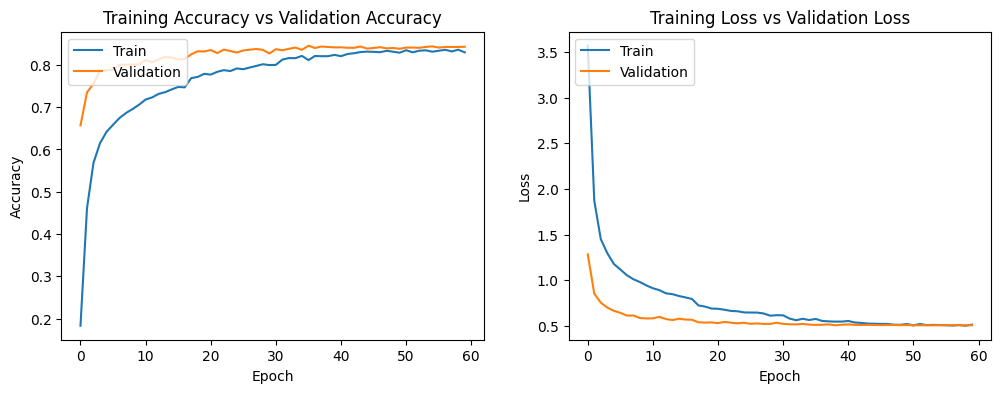

In [8]:
# Plots accuracy and loss plots
evaluate_plots(history)

In [9]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using weighted as the full dataset mbalanced is currently not addressed)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

65/65 [==============================] - 5s 63ms/step
Test Accuracy: 0.8460
Test Loss: 0.4820
Recall: 0.8439
F1 Score: 0.8414


In [10]:
model.save("models/resnet50_unfrozen.h5")

### <b>Experiment Results:</b> 
- Unfreezing the top layers did now provide any improvements to the model.  

#### Existing Setup Issues:
- Misclassification for some dog breeds still occur.
- Training time is slow (due to 20k images and data augmentations)

### <b>Prioritization:</b> Misclassification
We still prioritize further <b>reducing misclassificaiton</b> because our previous model evaluation shows that certain breeds, while improved a lot, are sometimes still sometimes misclassified. Directly targeting the few misclassified dog breeds should also have an impact the <b>diminishing model improvements</b> issue.


### <b>Analysis:</b> Potential Causes
- <b>Decoder undercapacity:</b> The decoder potentially cannot effectively refine or separate overlapping feature representations with only 2 layers.
- <b>Pretrained model limitation:</b> While ResNet50 provides strong general representations, it might not be fully capable of capturing more subtle, breed-specific variations needed for further improvement.

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Increase decoder depth :</b> Add additional layers or increase neuron count to enhance the decoder’s capacity to reduce misclassification for the frequently misclassified breeds.
- <b>2. Fusion model:</b> Supplement the current ResNet50-based model with an additional pretrained backbone such as Xception or InceptionV3 to create a fusion model that combines complementary feature representations, improving discrimination for frequently misclassified breeds. Findings in previous work (Ram, G. 2025) suggest that fusion models achieves higher accuracy on fine grained dog breed classification.

#### <b> Hypothesis chosen</b>: 2.
By inspecting realted work using the same dataset, many of the studies employ a model fusion strategy with great results. 

<b>Fusion model (H3) motivation reference:</b>
</br>
Sai Ram, G. (2025). Next-Gen dog breed identification using hybrid and custom CNN models. DOI:
https://www.doi.org/10.33545/27076571.2025.v6.i1b.138</br>
</br>
B. Valarmathi, N. S. Gupta, G. Prakash, R. H. Reddy, S. Saravanan and P. Shanmugasundaram, "Hybrid Deep Learning Algorithms for Dog Breed Identification—A Comparative Analysis," in IEEE Access, vol. 11, pp. 77228-77239, 2023, doi: 10.1109/ACCESS.2023.3297440


# Phase 5: Fusion Model

## Model Experiment 8: Model Fusion
### Hypothesis 2: Integrate the current setup in a fusion model in combination with Xception or InceptionV3 like in prior work with a weighting mechanism to further improve misclassified dog breeds (H2) as seens in research papers.

<b>Motivation for adding batch normalization in the decoder of Xception</b>
When training the Xception model, we use approximately the same decoder architecture as for ResNet50, but we include batch normalization to stabilize activations within the dense layers. This helps maintain consistent activation variance and improves convergence, reflecting Xception’s overall design philosophy, which relies on batch normalization for stable training behavior.

References: </br>
Santurkar, S., Tsipras, D., Ilyas, A., & Madry, A. (2019). "How Does Batch Normalization Help Optimization?". arXiv. DOI: https://doi.org/10.48550/arXiv.1502.03167 </br>
Ioffe, S., & Szegedy, C. (2015). "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift". arXiv. DOI: https://doi.org/10.48550/arXiv.1502.03167

Data augmentations for Xception model

In [93]:
# preproces input funciton for Xception model
from tensorflow.keras.applications.xception  import preprocess_input as preprocess_input_xception

# Image generators with data augmentation
xception_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_xception,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised )
xception_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception)

# Train generator
xception_train_generator = xception_train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(229, 229),
    class_mode='categorical',
    shuffle=True,
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
xception_val_generator = xception_test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(229, 229),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
xception_test_generator = xception_test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(229, 229),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


### Build Model

In [95]:
model_checkpoint_xcep = ModelCheckpoint(
    'models/xception.h5',
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)


Training an Xception model, we use approximately the same architecture as with the ResNet50 model but with batch normalization added bto stabilize the flow of activations through its depthwise separable convolutions to ensure stable variance during training. (without batch normalization, Xception converges very slow as the architecture assumes batch normalization after nearly every convolution)

## Fusion Model 1: Soft Vote Fusion
Model fusion at inference-time

In [96]:
# Encoder: The pretrained model
xception_encoder = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(229,229,3)
)

# Freeze all the encoder layers
for layer in xception_encoder.layers:
    layer.trainable = False

# Decoder: Classifier header to handle the 120 dog breeds 
x = GlobalAveragePooling2D()(xception_encoder.output)  # Global average pooling 

# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
x = Dense(1024, activation=None)(x)               # Linear transformation 1024 dimension
x = BatchNormalization()(x)                       # Normalize activations for training stability
x = Activation('relu')(x)                         # ReLU activation applied after normalization
x = Dropout(0.50)(x)                              # Dropout to random disable neurons during traing 

# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
x = Dense(512, activation=None)(x)                # Linear transformation 512 dimension
x = BatchNormalization()(x)                       # Normalize activations for training stability
x = Activation('relu')(x)                         # ReLU activation applied after normalization
x = Dropout(0.50)(x)                              # Dropout to random disable neurons during traing 

# Fully connected layer
xception_decoder = Dense(120, activation="softmax")(x)  

# Specify model
xception_model = Model(inputs=xception_encoder.input, outputs=xception_decoder)

# Scheduler (OneCycle)
# "One Cycle Learning Rate Policy for Keras", reference: Somshubra Majumdar https://github.com/titu1994/keras-one-cycle
scheduler = OneCycleLR(
    num_samples=len(df_train),
    batch_size=32,
    max_lr=0.05,
)

# Compile
xception_model.compile(
    optimizer = SGD(learning_rate=0.01), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [99]:
# Train model
xception_history = xception_model.fit(
    xception_train_generator,
    validation_data=xception_val_generator,
    epochs=50,
    callbacks=[scheduler, model_checkpoint_xcep],
    class_weight=class_weight_dict
)

Epoch 1/50
515/515 [==============================] - ETA: 0s - loss: 3.7755 - accuracy: 0.2157 - lr: 0.00700 - momentum: 0.95 

Epoch 1: val_accuracy improved from -inf to 0.84014, saving model to models\xception.h5
515/515 [==============================] - 116s 220ms/step - loss: 3.7755 - accuracy: 0.2157 - val_loss: 1.3518 - val_accuracy: 0.8401
Epoch 2/50
515/515 [==============================] - ETA: 0s - loss: 1.7842 - accuracy: 0.6269 - lr: 0.00900 - momentum: 0.94 

Epoch 2: val_accuracy improved from 0.84014 to 0.87512, saving model to models\xception.h5
515/515 [==============================] - 100s 194ms/step - loss: 1.7842 - accuracy: 0.6269 - val_loss: 0.6041 - val_accuracy: 0.8751
Epoch 3/50
515/515 [==============================] - ETA: 0s - loss: 1.2089 - accuracy: 0.7236 - lr: 0.01100 - momentum: 0.94 

Epoch 3: val_accuracy improved from 0.87512 to 0.87949, saving model to models\xception.h5
515/515 [==============================] - 100s 194ms/step - loss: 1.2089

Obtain the weakest dog breed classes of the base model (based on ResNet50)

In [104]:
# Predict with ResNet and get true labels
y_true = test_generator.classes
preds_res = model.predict(test_generator, verbose=1)
y_pred_res = np.argmax(preds_res, axis=1)

# Create classification report dataframe
class_report_3 = classification_report(
    y_true,
    y_pred_res,
    target_names=list(test_generator.class_indices.keys()),
    zero_division=0,
    output_dict=True
)
class_report_df_3 = pd.DataFrame(class_report_3).transpose()
class_report_df_3 = class_report_df_3.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")

# Select weak classes (F1 ≤ 0.80) and map to numeric indices: 80%
class_issues_df_3 = class_report_df_3[class_report_df_3['f1-score'] <= 0.80]  # there a
idx_map = test_generator.class_indices
weak_classes = [idx_map[breed] for breed in class_issues_df_3.index if breed in idx_map]
print(f"Weak classes: {weak_classes}")

65/65 [==============================] - 5s 60ms/step
Weak classes: [3, 4, 5, 9, 15, 20, 21, 22, 23, 24, 26, 34, 36, 41, 43, 47, 49, 54, 62, 63, 64, 65, 69, 73, 76, 77, 78, 89, 95, 101, 104, 105, 111, 112, 113, 114, 115, 116, 118]


There are more weak classes because we have set the threshold to 80% instead of 70% previously.

Model fusion at inference time(soft vote fusion)

In [105]:
# soft fusion and evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict with Xception
preds_xcep = xception_model.predict(xception_test_generator, verbose=1)

# Apply soft fusion for weak classes
fused_preds = preds_res.copy()
for i, pred in enumerate(preds_res):
    top_class = np.argmax(pred)
    if top_class in weak_classes:
        #fused_preds[i] = 0.9 * preds_res[i] + 0.1 * preds_xcep[i]   #70% xcep
        #fused_preds[i] = 0.5 * preds_res[i] + 0.5 * preds_xcep[i]   #50% xcep
        fused_preds[i] = preds_xcep[i]   #100% xcep for the weak breeds

# Final predictions and metrics
y_pred_fused = np.argmax(fused_preds, axis=1)
precision = precision_score(y_true, y_pred_fused, average='weighted')
recall = recall_score(y_true, y_pred_fused, average='weighted')
f1 = f1_score(y_true, y_pred_fused, average='weighted')
accuracy = np.mean(y_true == y_pred_fused)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

65/65 [==============================] - 4s 69ms/step
Accuracy: 0.8761
Precision: 0.8823
Recall: 0.8761
F1 Score: 0.8744


Save models

In [100]:
model.save("models/resnet50_best.h5")
xception_model.save("models/xception_best.h5")

Furhter comparison with unfused ResNet50-based model for overlapping dog breed classes

In [94]:
#reload model in newest run to evaluate more
model = load_model("models/resnet50_best.h5")
xception_model = load_model("models/xception_best.h5")

In [106]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

# Predictions 
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using macro)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Arrange by dog breed with struggles
class_report_3 = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)  # classificaiotn report as dict

# Convert to dataframe (trnapose and sort)
class_report_df_3 = pd.DataFrame(class_report_3).transpose()  #transpose
class_report_df_3= class_report_df_3.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore") #drop aggregated rows
class_report_df_3 = class_report_df_3.sort_values(by="f1-score", ascending=True) # arrange by f1

# Filter class df to get classes where the model struggles. We focues on the worst classes, as the good classes are very unlikely to have noticeable overlaps with these given their high accurecy
class_issues_df_3 = class_report_df_3[(class_report_df_3['f1-score'] <= 0.70)]

65/65 [==============================] - 4s 58ms/step


In [107]:
# Predict with both models
preds_res = model.predict(test_generator, verbose=1)
preds_xcep = xception_model.predict(xception_test_generator, verbose=1)

# Classification reports for both
class_report_res = classification_report(
    y_true,
    np.argmax(preds_res, axis=1),
    target_names=list(test_generator.class_indices.keys()),
    zero_division=0,
    output_dict=True
)
class_report_df_res = pd.DataFrame(class_report_res).transpose()
class_report_df_res = class_report_df_res.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")

class_report_xcep = classification_report(
    y_true,
    np.argmax(preds_xcep, axis=1),
    target_names=list(test_generator.class_indices.keys()),
    zero_division=0,
    output_dict=True
)
class_report_df_xcep = pd.DataFrame(class_report_xcep).transpose()
class_report_df_xcep = class_report_df_xcep.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")

# Identify weak ResNet classes (F1 ≤ 0.70)
class_issues_df_res = class_report_df_res[class_report_df_res['f1-score'] <= 0.70]

# Start from Xception predictions
fused_preds = preds_xcep.copy()

# Identify classes where ResNet is better
class_f1_res = class_report_df_res["f1-score"].to_dict()
class_f1_xcep = class_report_df_xcep["f1-score"].to_dict()
resnet_better_classes = [
    cls for cls in class_f1_res.keys()
    if class_f1_res.get(cls, 0) > class_f1_xcep.get(cls, 0)
]

# Map breed name to numeric index
idx_map = test_generator.class_indices
resnet_better_ids = [idx_map[c] for c in resnet_better_classes if c in idx_map]

# For those classes only, if ResNet is more confident, take its prediction
for i in range(len(preds_res)):
    top_res = np.argmax(preds_res[i])
    top_xcep = np.argmax(preds_xcep[i])
    if top_res in resnet_better_ids and np.max(preds_res[i]) > np.max(preds_xcep[i]):
        fused_preds[i] = preds_res[i]

# Final fused predictions
y_pred_fused = np.argmax(fused_preds, axis=1)

# Metrics
precision = precision_score(y_true, y_pred_fused, average='weighted')
recall = recall_score(y_true, y_pred_fused, average='weighted')
f1 = f1_score(y_true, y_pred_fused, average='weighted')
accuracy = np.mean(y_true == y_pred_fused)

print(f"Selective Fusion (Xception base + ResNet only when better):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")


65/65 [==============================] - 4s 69ms/step
Selective Fusion (Xception base + ResNet only when better):
Accuracy: 0.9048
Precision: 0.9083
Recall: 0.9048
F1: 0.9044


In [129]:
# Predict with both models
preds_res = model.predict(test_generator, verbose=1)
preds_xcep = xception_model.predict(xception_test_generator, verbose=1)

# Start from Xception predictions
fused_preds = preds_xcep.copy()

# Identify classes where ResNet is better
class_f1_res = class_report_df_res["f1-score"].to_dict()
class_f1_xcep = class_report_df_xcep["f1-score"].to_dict()
resnet_better_classes = [
    cls for cls in class_f1_res.keys()
    if class_f1_res.get(cls, 0) > class_f1_xcep.get(cls, 0)
]

# Map breed name to numeric index
idx_map = test_generator.class_indices
resnet_better_ids = [idx_map[c] for c in resnet_better_classes if c in idx_map]

# For those classes only, if ResNet is more confident, take its prediction
for i in range(len(preds_res)):
    top_res = np.argmax(preds_res[i])
    top_xcep = np.argmax(preds_xcep[i])
    if top_res in resnet_better_ids and np.max(preds_res[i]) > np.max(preds_xcep[i]):
        fused_preds[i] = preds_res[i]

# Final fused predictions
y_pred_fused = np.argmax(fused_preds, axis=1)

# Metrics
precision = precision_score(y_true, y_pred_fused, average='weighted')
recall = recall_score(y_true, y_pred_fused, average='weighted')
f1 = f1_score(y_true, y_pred_fused, average='weighted')
accuracy = np.mean(y_true == y_pred_fused)

print(f"Selective Fusion (Xception base + ResNet only when better):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")


65/65 [==============================] - 4s 65ms/step
Selective Fusion (Xception base + ResNet only when better):
Accuracy: 0.9057
Precision: 0.9105
Recall: 0.9057
F1: 0.9051


In [109]:
# Misclassification counts: Reesnet vs. fusion model
resnet_mis = np.sum(y_true != np.argmax(preds_res, axis=1))
fused_mis = np.sum(y_true != y_pred_fused)

print(f"Total misclassifications (ResNet): {resnet_mis}")
print(f"Total misclassifications (Fused): {fused_mis}")
print(f"Improvement: {resnet_mis - fused_mis} fewer errors in total with a soft fusion model")

Total misclassifications (ResNet): 321
Total misclassifications (Fused): 196
Improvement: 125 fewer errors in total with a soft fusion model


Misclassificaiton distribution : confusion matrix

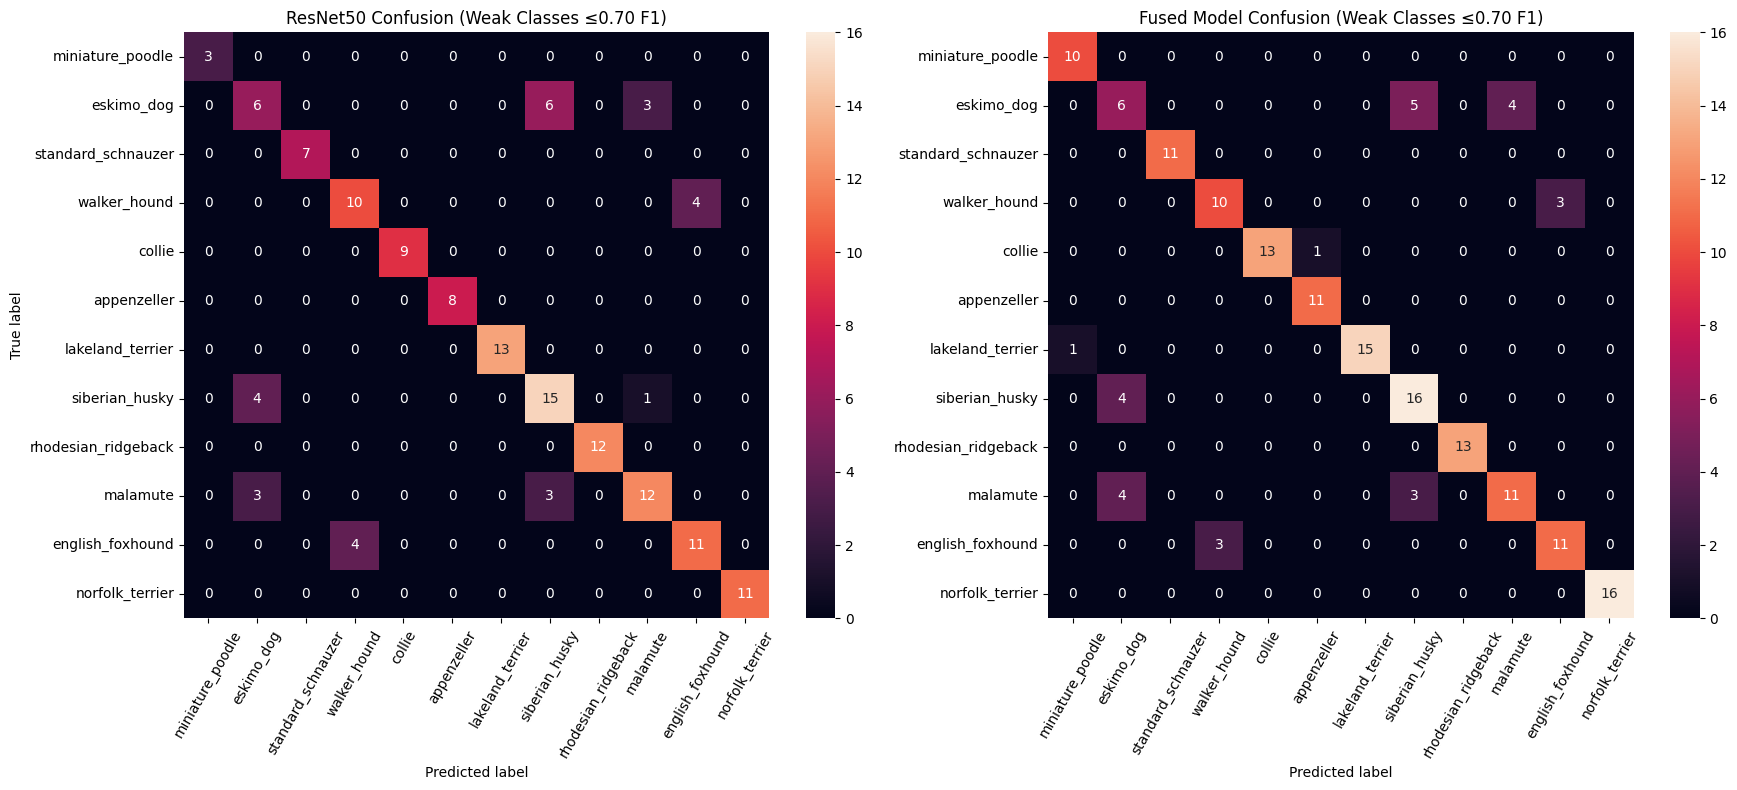

Total misclassifications (ResNet weak classes ≤0.70 F1): 83
Total misclassifications (Fusion weak classes ≤0.70 F1): 57
Improvement: 26 fewer errors with fusion


In [110]:
# Weak class list (ResNet ≤ 0.70 F1)
class_issues_lst_3 = class_issues_df_3.index.tolist()
class_issues_norm = [c.strip().lower() for c in class_issues_lst_3]

# Map class names (breeds)
breed_name_mapping = {val: breed for breed, val in test_generator.class_indices.items()}

# Normalize all names
y_true_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_true])
y_pred_res_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_pred_res])
y_pred_fused_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_pred_fused])

# Filter: only samples whose true class is in weak list
mask = y_true_map_norm.isin(class_issues_norm)
y_true_issue = y_true_map_norm[mask].reset_index(drop=True)
y_pred_res_issue = y_pred_res_map_norm[mask].reset_index(drop=True)
y_pred_fused_issue = y_pred_fused_map_norm[mask].reset_index(drop=True)

# Confusion matrices (use normalized labels)
conf_res = confusion_matrix(y_true_issue, y_pred_res_issue, labels=class_issues_norm)
conf_fused = confusion_matrix(y_true_issue, y_pred_fused_issue, labels=class_issues_norm)

# Match color scale for fair visual comparison
vmax = max(conf_res.max(), conf_fused.max())

# Confusion matrices plot: side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Resnet 50 conf matrix
sns.heatmap(conf_res, annot=True, fmt='d',
            xticklabels=class_issues_norm, yticklabels=class_issues_norm,
            ax=axes[0], vmin=0, vmax=vmax)
axes[0].set_title('ResNet50 Confusion (Weak Classes ≤0.70 F1)')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')
axes[0].tick_params(axis='x', rotation=60)

# Soft fusion confusion matrix 
sns.heatmap(conf_fused, annot=True, fmt='d',
            xticklabels=class_issues_norm, yticklabels=class_issues_norm,
            ax=axes[1], vmin=0, vmax=vmax)
axes[1].set_title('Fused Model Confusion (Weak Classes ≤0.70 F1)')
axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

# Misclassification totals (weak classes only)
resnet_mis = np.sum(y_true_issue != y_pred_res_issue)
fused_mis = np.sum(y_true_issue != y_pred_fused_issue)
print(f"Total misclassifications (ResNet weak classes ≤0.70 F1): {resnet_mis}")
print(f"Total misclassifications (Fusion weak classes ≤0.70 F1): {fused_mis}")
print(f"Improvement: {resnet_mis - fused_mis} fewer errors with fusion")


In general we see an large decrease in misclassifications for the fusion model compared to the ResNet50 model alone (observed by the total count and correct predictions in the diagonal). However, the same overlaps as previous observed (which even got worse for Siberain Husky > Eskimo Dog)

## Fusion Model 2: Feature-level Fusion
- The simple soft fusion at test time, showed that combining the two models improve misclassificaiton issues (and the overall performance). Laying the neccesary groundwork before combining the ResNet50 and the Xception model at feature-level, which can potentially further improve the misclassificaiton.
- Xception dropout rates are reduced because minor underfitting was observed during training.

#### Combining ResNet50 and Xception ImageDataGenerator's

- Xception data augmentations: Resized to 224x224 to maintain dimensions across models. 
- Disable shuffling for both ResNet and Xception ImageDataGenerator

In [111]:
# Image generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
    #fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.6, 1.1] 
)

# Test data (only normalised using preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,  # import to not shuffle for fusion models
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


#xception:
# Image generators with data augmentation: resize xceptions generators
xception_train_datagen = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input_xception,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised )
#xception_test_datagen = ImageDataGenerator(rescale=1./255)
xception_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception)


# Train generator
xception_train_generator = xception_train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,     # import to not shuffle for fusion models
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
xception_val_generator = xception_test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
xception_test_generator = xception_test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


Combined Resnet50 and Xeception data augmentations

In [112]:
# Function to combine the imagegenerators: synchronizes theirs outputs while ensure batch size match
# Reference: 2019,Zaccharie Ramzi, https://stackoverflow.com/questions/46313525/how-do-i-combine-two-keras-generator-functions
from tensorflow.keras.utils import Sequence

# Helper function for combined the two imagegenerators
class create_fusion_generators(Sequence):
    def __init__(self, resnet_gen, xception_gen):
        self.resnet_gen = resnet_gen                          # Generator for ResNet imagegenerators (data augmentation input)
        self.xception_gen = xception_gen                      # Generator for Xception imagegenerators (data augmentation input)
        self.length = min(len(resnet_gen), len(xception_gen)) # Ensures equall no. of batches
    
    def __len__(self):
        return self.length                                    # Total no. of batch per epoch

    def __getitem__(self, idx):
        resnet_images, labels = self.resnet_gen[idx]          # ResNet batches (images & labels)
        xception_images, _ = self.xception_gen[idx]           # Xception batches (images & labels)
        return [resnet_images, xception_images], labels       # Return synchronized imagegenerators and shrared labels

In [113]:
model_checkpoint_fusion = ModelCheckpoint(
    'models/fusion_res_xcep.h5',
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

In [115]:
from tensorflow.keras.layers import Concatenate

# Encoder 1: The pretrained model (ResNet50)
resnet_encoder = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all the encoder layers
for layer in resnet_encoder.layers:
    layer.trainable = False

# Encoder 2: The pretrained model (Xception)
xception_encoder = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)                                   # Using a consistent input size with ResNet50 instead of the normal (229x229)
)

# Freeze all the encoder layers
for layer in xception_encoder.layers:
    layer.trainable = False

# Decoder: ResNet50 branch
resnet_x = GlobalAveragePooling2D()(resnet_encoder.output)      # Convert the encoders 3D feature maps (h, w, c) into an 1D vector
# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
resnet_x = Dense(512, activation="relu")(resnet_x)              # Non-linear transformation 512 dimension (new hidden layer)
resnet_x = Dropout(0.5)(resnet_x)                              # 1st dropout to random disable neurons during traing to combat overfitting
# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
resnet_x = Dense(256, activation="relu")(resnet_x)              # Non-linear transformation 256 dimension (new hidden layer)
resnet_x = Dropout(0.35)(resnet_x)                              # 2nd dropout to random disable neurons during traing to combat overfitting

# Decoder: Xception branch (with batch normalization)
xception_x = GlobalAveragePooling2D()(xception_encoder.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector
# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
xception_x = Dense(1024, activation=None)(xception_x)            # Linear transformation
xception_x = BatchNormalization()(xception_x)                    # Normalize activations for training stability
xception_x = Activation('relu')(xception_x)                      # ReLU activation applied after normalization
xception_x = Dropout(0.45)(xception_x)                           # 1st dropout to random disable neurons during traing to combat overfitting
# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
xception_x = Dense(512, activation=None)(xception_x)             # Linear transformation
xception_x = BatchNormalization()(xception_x)                    # Normalize activations for training stability
xception_x = Activation('relu')(xception_x)                      # ReLU activation applied after normalization
xception_x = Dropout(0.40)(xception_x)                           # 2nd dropout to random disable neurons during traing to combat overfitting

# Combine Decoder: feature-level fusion
x = Concatenate()([resnet_x, xception_x])                        # Merge both feature vectors into a single representation
# Normalize the fused features to align different the activation scales of ResNet50 and Xception to stabilize training (https://arxiv.org/abs/1502.03167 & https://arxiv.org/abs/1805.11604)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Decoder: Shared layer
x = Dense(256, activation="relu")(x)                             # Non-linear transformation 256 dimension for combine feature learning
#x = Dropout(0.2)(x)                                             # 3rd dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connected layer
decoder = Dense(120, activation="softmax")(x)                    # Output layer for 120 dog breed classes

# Specify model
fusion_model = Model(inputs=[resnet_encoder.input, xception_encoder.input], outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
fusion_model.compile(
    optimizer=SGD(learning_rate=0.03),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [117]:
lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=3,       
    min_lr=1e-6, 
    verbose=1
)

In [118]:
# Combined the iamgegenerators: I.e. each data augmentations pipeline applies its own preprocessing (preprocess_input for ResNet, and rescale=1./255 for Xception) 
train_fusion_generator = create_fusion_generators(train_generator, xception_train_generator)
val_fusion_generator   = create_fusion_generators(val_generator, xception_val_generator)
test_fusion_generator  = create_fusion_generators(test_generator, xception_test_generator)

# Train model
fusion_history = fusion_model.fit(
    train_fusion_generator,
    validation_data=val_fusion_generator,
    epochs=50,
    
    callbacks=[lr_plateau, model_checkpoint_fusion],    
    class_weight=class_weight_dict
)

Epoch 1/50
515/515 [==============================] - ETA: 0s - loss: 2.2604 - accuracy: 0.5007
Epoch 1: val_accuracy improved from -inf to 0.85083, saving model to models\fusion_res_xcep.h5
515/515 [==============================] - 199s 378ms/step - loss: 2.2604 - accuracy: 0.5007 - val_loss: 0.5467 - val_accuracy: 0.8508 - lr: 0.0300
Epoch 2/50
515/515 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.7467
Epoch 2: val_accuracy improved from 0.85083 to 0.87026, saving model to models\fusion_res_xcep.h5
515/515 [==============================] - 191s 371ms/step - loss: 0.8759 - accuracy: 0.7467 - val_loss: 0.4247 - val_accuracy: 0.8703 - lr: 0.0300
Epoch 3/50
515/515 [==============================] - ETA: 0s - loss: 0.7391 - accuracy: 0.7795
Epoch 3: val_accuracy improved from 0.87026 to 0.87609, saving model to models\fusion_res_xcep.h5
515/515 [==============================] - 193s 374ms/step - loss: 0.7391 - accuracy: 0.7795 - val_loss: 0.4052 - val_accurac

Save model

In [119]:
fusion_model.save("models/fusion_res_xcept_best.h5")

## <b>Evaluation:</b> Identify issues with the current setup

Plot accuracy and loss curves

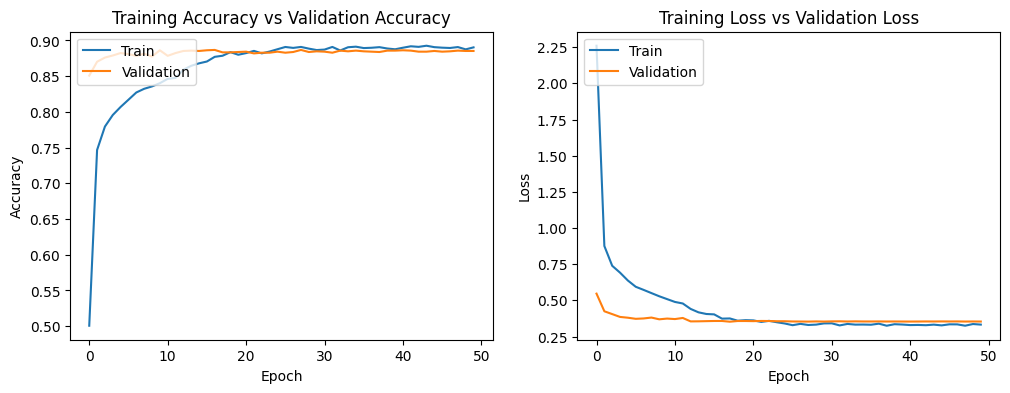

In [121]:
# Plots accuracy and loss plots
evaluate_plots(fusion_history)

Check model generalization using the unseen test data

In [127]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = fusion_model.evaluate(test_fusion_generator, steps=len(test_fusion_generator), verbose=1)

# Predictions 
y_pred = fusion_model.predict(test_fusion_generator, steps=len(test_fusion_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using weighted as the full dataset mbalanced is currently not addressed)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

65/65 [==============================] - 8s 122ms/step
Test Accuracy: 0.9052
Test Loss: 0.3070
Recall: 0.9033
F1 Score: 0.9023


In [123]:
# Arrange by dog breed with struggles

# Classificaiotn report as dict
class_report_3 = classification_report(
    y_true,
    y_pred_classes,
    target_names=test_fusion_generator.resnet_gen.class_indices.keys(),
    output_dict=True
)

# Convert to dataframe (trnapose and sort)
class_report_df_3 = pd.DataFrame(class_report_3).transpose()  #transpose
class_report_df_3= class_report_df_3.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore") #drop aggregated rows
class_report_df_3 = class_report_df_3.sort_values(by="f1-score", ascending=True) # arrange by f1

# Filter class df to get classes where the model struggles. We focues on the worst classes, as the good classes are very unlikely to have noticeable overlaps with these given their high accurecy
class_issues_df_3 = class_report_df_3[(class_report_df_3['f1-score'] <= 0.70)]
class_issues_df_3

precision    recall  f1-score  support
Eskimo_dog                       0.400000  0.400000  0.400000     15.0
Siberian_husky                   0.608696  0.700000  0.651163     20.0
miniature_poodle                 0.666667  0.666667  0.666667     15.0
American_Staffordshire_terrier   0.733333  0.647059  0.687500     17.0

In [124]:
print(len(class_issues_df_3))

4


The misclassified breeds decreased from 13 to 6 by reducing the underlying noise in the data by cropping the images to the bounding boxes provided in the annotations.

In [131]:
# Convert fused feature predictions to class indices
y_pred_fused_feat_classes = np.argmax(y_pred, axis=1)

# Normalize all names
y_true_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_true])
y_pred_res_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_pred_res])
y_pred_fused_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_pred_fused])
y_pred_fused_feat_map_norm = pd.Series([breed_name_mapping[i].strip().lower() for i in y_pred_fused_feat_classes])

# Filter: only samples whose true class is in weak list
mask = y_true_map_norm.isin(class_issues_norm)
y_true_issue = y_true_map_norm[mask].reset_index(drop=True)
y_pred_res_issue = y_pred_res_map_norm[mask].reset_index(drop=True)
y_pred_fused_issue = y_pred_fused_map_norm[mask].reset_index(drop=True)
y_pred_fused_feat_issue = y_pred_fused_feat_map_norm[mask].reset_index(drop=True)

# Misclassification totals (weak classes only)
resnet_mis = np.sum(y_true_issue != y_pred_res_issue)
fused_mis = np.sum(y_true_issue != y_pred_fused_issue)
fused_mis_feat = np.sum(y_true_issue != y_pred_fused_feat_issue)

print(f"Total misclassifications (ResNet weak classes ≤0.70 F1): {resnet_mis}")
print(f"Total misclassifications (Soft Fusion weak classes ≤0.70 F1): {fused_mis}")
print(f"Total misclassifications (Feature-level Fusion weak classes ≤0.70 F1): {fused_mis_feat}")
print(f"Improvement: {resnet_mis - fused_mis} fewer errors with soft fusion")
print(f"Improvement: {resnet_mis - fused_mis_feat} fewer errors with feature-level fusion")

Total misclassifications (ResNet weak classes ≤0.70 F1): 83
Total misclassifications (Soft Fusion weak classes ≤0.70 F1): 57
Total misclassifications (Feature-level Fusion weak classes ≤0.70 F1): 59
Improvement: 26 fewer errors with soft fusion
Improvement: 24 fewer errors with feature-level fusion


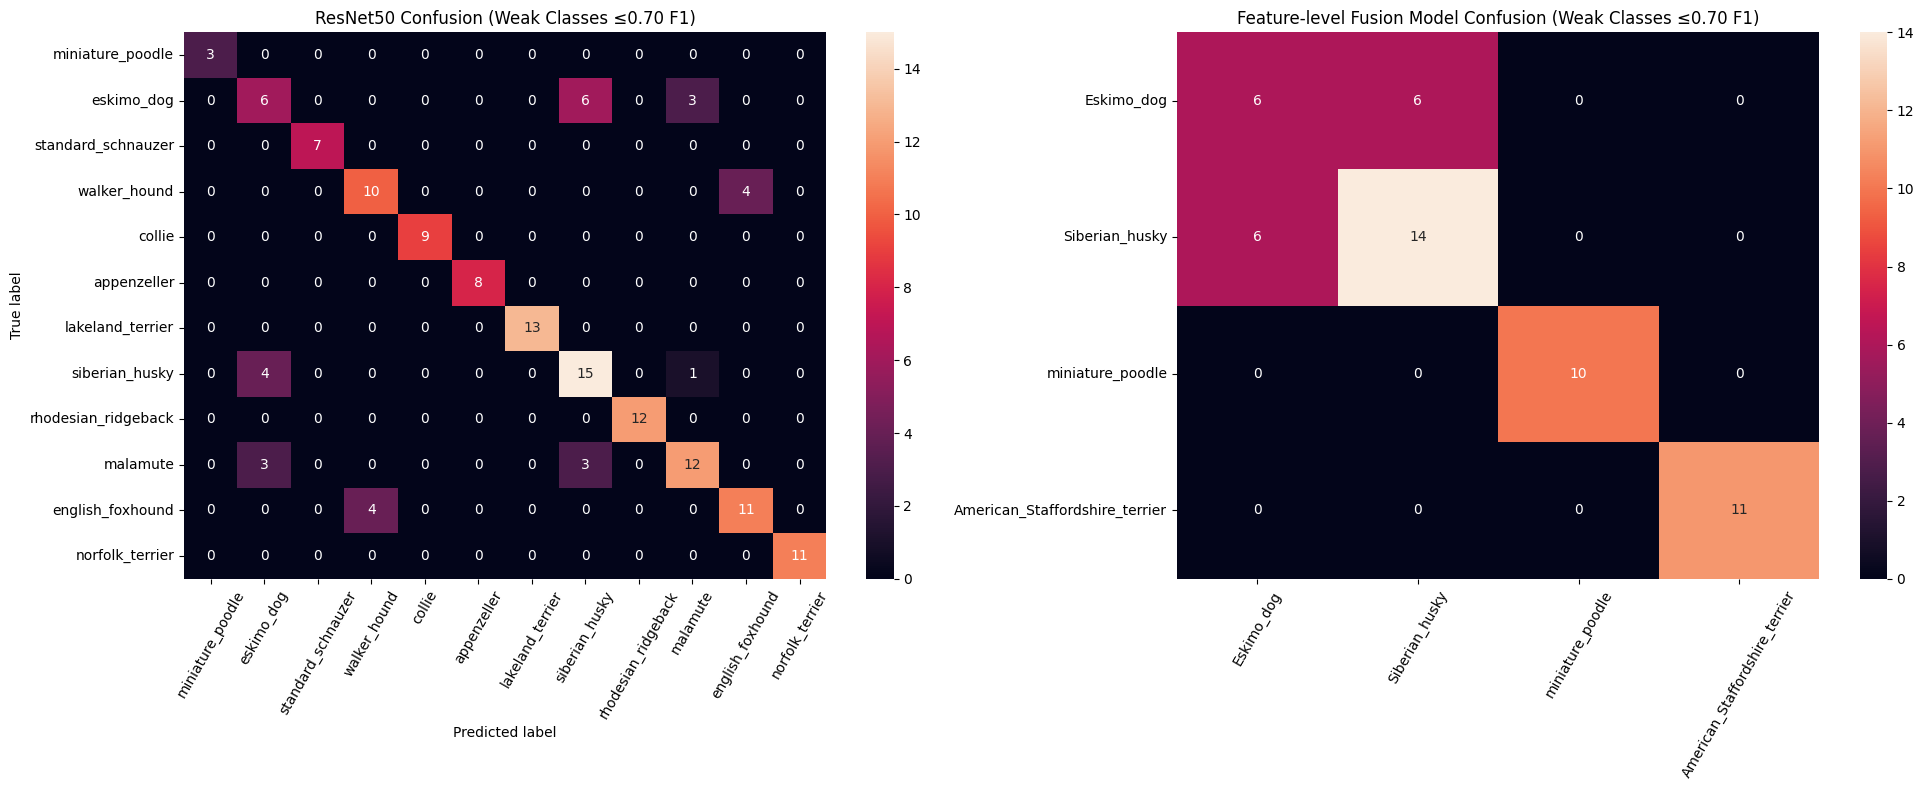

In [126]:
# Get the true classes and their prediction for the dog breed we identified as struggling above: convert to list
class_issues_lst_3 = class_issues_df_3.index.tolist()

# Map class names (breeds) 
breed_name_mapping = {val: breed for breed, val in test_fusion_generator.resnet_gen.class_indices.items()}

# Apply the class name mapping to ground truth and predictions and convert to pd series
y_true_map = [breed_name_mapping[i] for i in y_true]          # True y mapped
y_true_map = pd.Series(y_true_map)                            # Convert True y mapped to series
y_pred_map = [breed_name_mapping[i] for i in y_pred_classes]  # Predictiomns mapped
y_pred_map = pd.Series(y_pred_map)                            # Convert TPredictiomnsmapped to series

# True lbel os the issue classes (boolean mask)
class_issues_mask = y_true_map.isin(class_issues_lst_3)

# Applu the class issue mask to filter out dog breeds without issues
y_true_issue = y_true_map[class_issues_mask]  # Exlucde correct predicted breeds
y_pred_issue = y_pred_map[class_issues_mask] # Match samples

# Create dataframe for misclassifcaitons
# Add image file paths
file_paths = pd.Series(test_generator.filepaths)

# Apply class issue mask to filter images for weakest breeds
paths_issue = file_paths[class_issues_mask]

# Create final DataFrame for misclassifications
df_issue_3 = pd.DataFrame({
    "path": paths_issue.values,
    "true": y_true_issue.values,
    "pred": y_pred_issue.values
}).reset_index(drop=True)


# Confusion matrix
conf_matrix_4 = confusion_matrix(y_true_issue, y_pred_issue, labels=class_issues_lst_3)

# Plot confusion matrix: side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Resnet 50 conf matrix
sns.heatmap(conf_res, annot=True, fmt='d',
            xticklabels=class_issues_norm, yticklabels=class_issues_norm,
            ax=axes[0])
axes[0].set_title('ResNet50 Confusion (Weak Classes ≤0.70 F1)')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')
axes[0].tick_params(axis='x', rotation=60)

# feature-level fusion model (resnet50/xception)  conf matrix
sns.heatmap(conf_matrix_4, annot=True, fmt='d',
            xticklabels=class_issues_lst_3, yticklabels=class_issues_lst_3,
            ax=axes[1])
axes[1].set_title('Feature-level Fusion Model Confusion (Weak Classes ≤0.70 F1)')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')
axes[1].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

### <b>Experiment Results:</b> 
- For the soft-vote fusion model at inference-time, the misclassification (and dog breed overlap) issue is significantly improved. 
- The feature-level fusion model is the best performing model, it also significantly  performance while also improving the misclassification issue.
- Misclassification for dog breed that still occur are unlikely to be fixed inspecting the images because they very similar, to a point that is not human distinguisable by an untrained eye either.
- Although the Xception architecture differs a lot from ResNet50, the previous observed overlaps, although improved, is still present.
- The current setup is significantly better at classificaiton the overlapping dog breeds. However, while with a lot less impact, they do still occur for Eskimo <-> Siberian Husky and Toy Poodle <-> Miniature Poodle, but the class weakness is largely mitigated (see results below.).
- No. of misclassified breeds (f1-score below 70) decrease to 4 breeds [now] opposed to 13 [exp 5] and 28 [exp 4]


### <b>Model Setup Issues:</b> 
- Misclassification for some dog breeds still occur: Same breeds (overlaps) are still prone to misclassification.

#### Existing Setup Issues:
- Training time is slow (due to 20k images and data augmentations)

### <b>Prioritization:</b> Misclassification
We still prioritize <b>misclassification</b> as this still seems to be the best possible way to achive better model performance in general and this will likely improve the real-world application, a area which prior work doesnt give much focus. Reducing the training time does not seems feasible without having to compomise the performance.

### <b>Analysis:</b> Potential Causes
- <b>Overlapping fine-grained features:</b> The misclassified dogs look very much a like, and might be too hard to tell apart for the current setup as it focuses a lot on the head areas.
- <b>Fusion models does not complement each other:</b> Even though the two models that comprises the current setup is chosen because of their architectural differences, it may be likely that other pre-trained models would complement the baseline ResNet50 architecture better.
- <b>Limited fine-tuning:</b> Keeping both the encoder layers frozen prevents adaptation of high-level dog breed features.

### <b>Hypotheses:</b> Potential Solutions
- <b>1. Unfreeze both encoder layers:</b> Unfreeze some of the top layers both of the encoders to allow for further fine-tuning to adapt pretrained features for fine-grained breed distinctions to potentially reduce misclassification for the frequently misclassified breeds.

#### <b> Hypothesis chosen</b>: 1.
Unfreezing top layers in both encoders, could potentially allow for better fine-grained dog breed distinctions.

## Model Experiment 9: Unfreezing Top Layers in  the Fusion Model
### Hypothesis 1: Unfreeze some of the top layers both of the encoders to allow for further fine-tuning

In [11]:
from tensorflow.keras.applications.xception  import preprocess_input as preprocess_input_xception

# Image generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
    #fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.6, 1.1] 
)

# Test data (only normalised using preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,  # import to not shuffle for fusion models
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


#xception:
# Image generators with data augmentation: resize xceptions generators
xception_train_datagen = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input_xception,
    rotation_range=20,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    horizontal_flip=True,  
   # fill_mode='nearest',       # Mitigate potential empty pixels from above operations: default
    #shear_range=10,            
    #zoom_range=0.2,             
    #brightness_range=[0.9, 1.1] 
)

# Test data (only normalised )
#xception_test_datagen = ImageDataGenerator(rescale=1./255)
xception_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception)


# Train generator
xception_train_generator = xception_train_datagen.flow_from_dataframe(
    df_train,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,     # import to not shuffle for fusion models
    random_seed = 42,
    batch_size=32
    #batch_size=64
)

# Val generator
xception_val_generator = xception_test_datagen.flow_from_dataframe(
    df_val,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64        
)

# Test generator
xception_test_generator = xception_test_datagen.flow_from_dataframe(
    df_test,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    random_seed = 42,
    batch_size=32
    #batch_size=64         
)


Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


In [12]:
# Function to combine the imagegenerators: synchronizes theirs outputs while ensure batch size match
# Reference: 2019,Zaccharie Ramzi, https://stackoverflow.com/questions/46313525/how-do-i-combine-two-keras-generator-functions
from tensorflow.keras.utils import Sequence

# Helper function for combined the two imagegenerators
class create_fusion_generators(Sequence):
    def __init__(self, resnet_gen, xception_gen):
        self.resnet_gen = resnet_gen                          # Generator for ResNet imagegenerators (data augmentation input)
        self.xception_gen = xception_gen                      # Generator for Xception imagegenerators (data augmentation input)
        self.length = min(len(resnet_gen), len(xception_gen)) # Ensures equall no. of batches
    
    def __len__(self):
        return self.length                                    # Total no. of batch per epoch

    def __getitem__(self, idx):
        resnet_images, labels = self.resnet_gen[idx]          # ResNet batches (images & labels)
        xception_images, _ = self.xception_gen[idx]           # Xception batches (images & labels)
        return [resnet_images, xception_images], labels       # Return synchronized imagegenerators and shrared labels

In [13]:
model_checkpoint_fusion = ModelCheckpoint(
    'models/fusion_res_xcep_UNFROZEN.h5',
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

In [14]:
model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Unfreeze some of the encoder layers
for layer in model.layers[:-3]:
    layer.trainable = False
for layer in model.layers[-3:]:
    layer.trainable = True

In [15]:
from tensorflow.keras.layers import Concatenate

# Encoder 1: The pretrained model (ResNet50)
resnet_encoder = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# unfree last  the encoder layers  
for layer in resnet_encoder.layers[:-3]:
    layer.trainable = False
for layer in resnet_encoder.layers[-3:]:
    layer.trainable = True


# Encoder 2: The pretrained model (Xception)
xception_encoder = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)                                   # Using a consistent input size with ResNet50 instead of the normal (229x229)
)

# unfree last  the encoder layers  
for layer in xception_encoder.layers[:-3]:
    layer.trainable = False
for layer in xception_encoder.layers[-3:]:
    layer.trainable = True


# Decoder: ResNet50 branch
resnet_x = GlobalAveragePooling2D()(resnet_encoder.output)      # Convert the encoders 3D feature maps (h, w, c) into an 1D vector
# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
resnet_x = Dense(512, activation="relu")(resnet_x)              # Non-linear transformation 512 dimension (new hidden layer)
resnet_x = Dropout(0.5)(resnet_x)                              # 1st dropout to random disable neurons during traing to combat overfitting
# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
resnet_x = Dense(256, activation="relu")(resnet_x)              # Non-linear transformation 256 dimension (new hidden layer)
resnet_x = Dropout(0.35)(resnet_x)                              # 2nd dropout to random disable neurons during traing to combat overfitting

# Decoder: Xception branch (with batch normalization)
xception_x = GlobalAveragePooling2D()(xception_encoder.output)   # Convert the encoders 3D feature maps (h, w, c) into an 1D vector
# Decoder: Layer 1 - First hidden layer with regularization to mitigate overfitting
xception_x = Dense(1024, activation=None)(xception_x)            # Linear transformation
xception_x = BatchNormalization()(xception_x)                    # Normalize activations for training stability
xception_x = Activation('relu')(xception_x)                      # ReLU activation applied after normalization
xception_x = Dropout(0.45)(xception_x)                           # 1st dropout to random disable neurons during traing to combat overfitting
# Decoder: Layer 2 - Second hidden layer with regularization to mitigate overfitting
xception_x = Dense(512, activation=None)(xception_x)             # Linear transformation
xception_x = BatchNormalization()(xception_x)                    # Normalize activations for training stability
xception_x = Activation('relu')(xception_x)                      # ReLU activation applied after normalization
xception_x = Dropout(0.40)(xception_x)                           # 2nd dropout to random disable neurons during traing to combat overfitting

# Combine Decoder: feature-level fusion
x = Concatenate()([resnet_x, xception_x])                        # Merge both feature vectors into a single representation
# Normalize the fused features to align different the activation scales of ResNet50 and Xception to stabilize training (https://arxiv.org/abs/1502.03167 & https://arxiv.org/abs/1805.11604)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Decoder: Shared layer
x = Dense(256, activation="relu")(x)                             # Non-linear transformation 256 dimension for combine feature learning
#x = Dropout(0.2)(x)                                             # 3rd dropout to random disable neurons during traing to combat overfitting

# Decoder: Fully connected layer
decoder = Dense(120, activation="softmax")(x)                    # Output layer for 120 dog breed classes

# Specify model
fusion_model2 = Model(inputs=[resnet_encoder.input, xception_encoder.input], outputs=decoder)

# Compile the model using Stochastic Gradient Descent as optimizer and categorical_crossentropy because we are using dog breed labels from the dataframe
fusion_model2.compile(
    optimizer=SGD(learning_rate=0.03),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=3,       
    min_lr=1e-6, 
    verbose=1
)

In [17]:
# Combined the iamgegenerators: I.e. each data augmentations pipeline applies its own preprocessing (preprocess_input for ResNet, and rescale=1./255 for Xception) 
train_fusion_generator = create_fusion_generators(train_generator, xception_train_generator)
val_fusion_generator   = create_fusion_generators(val_generator, xception_val_generator)
test_fusion_generator  = create_fusion_generators(test_generator, xception_test_generator)

# Train model
fusion_history2 = fusion_model2.fit(
    train_fusion_generator,
    validation_data=val_fusion_generator,
    epochs=60,
    
    callbacks=[lr_plateau, model_checkpoint_fusion],    
    class_weight=class_weight_dict
)

Epoch 1/60
515/515 [==============================] - ETA: 0s - loss: 2.1844 - accuracy: 0.5166
Epoch 1: val_accuracy improved from -inf to 0.85326, saving model to models\fusion_res_xcep_UNFROZEN.h5
515/515 [==============================] - 189s 358ms/step - loss: 2.1844 - accuracy: 0.5166 - val_loss: 0.5392 - val_accuracy: 0.8533 - lr: 0.0300
Epoch 2/60
515/515 [==============================] - ETA: 0s - loss: 0.8654 - accuracy: 0.7553
Epoch 2: val_accuracy improved from 0.85326 to 0.87075, saving model to models\fusion_res_xcep_UNFROZEN.h5
515/515 [==============================] - 185s 359ms/step - loss: 0.8654 - accuracy: 0.7553 - val_loss: 0.4290 - val_accuracy: 0.8707 - lr: 0.0300
Epoch 3/60
515/515 [==============================] - ETA: 0s - loss: 0.7478 - accuracy: 0.7828
Epoch 3: val_accuracy improved from 0.87075 to 0.87804, saving model to models\fusion_res_xcep_UNFROZEN.h5
515/515 [==============================] - 184s 357ms/step - loss: 0.7478 - accuracy: 0.7828 - val

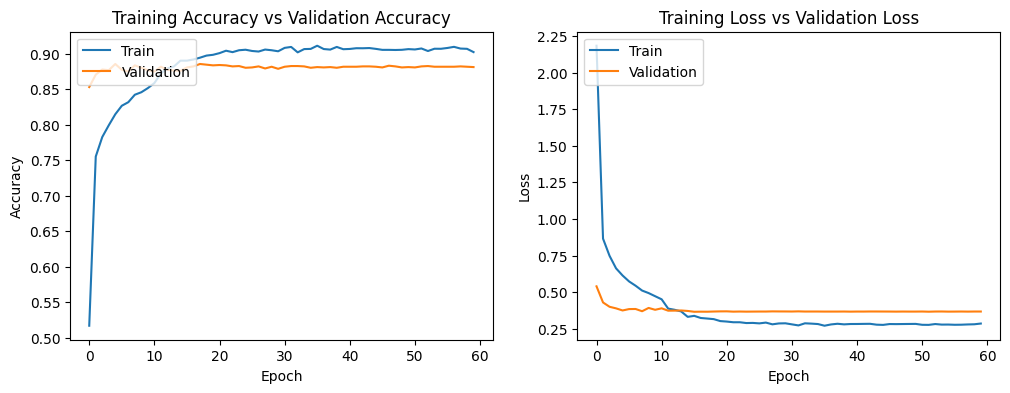

In [18]:
# Plots accuracy and loss plots
evaluate_plots(fusion_history2)

In [19]:
# Evaluate model on unseen test data set (full)
test_loss, test_accuracy = fusion_model2.evaluate(test_fusion_generator, steps=len(test_fusion_generator), verbose=1)

# Predictions 
y_pred = fusion_model2.predict(test_fusion_generator, steps=len(test_fusion_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth y
y_true = test_generator.classes

# Compute precision, recall, F1 score. ((Using weighted as the full dataset mbalanced is currently not addressed)
recall = recall_score(y_true, y_pred_classes, average='macro')        # Recall: Using macro to see the effect on true dataset class distribution
f1 = f1_score(y_true, y_pred_classes, average='macro')                # F1 score: Using macro to see the effect on true dataset class distribution

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

65/65 [==============================] - 11s 152ms/step
Test Accuracy: 0.9009
Test Loss: 0.3137
Recall: 0.8980
F1 Score: 0.8976


In [20]:
# Arrange by dog breed with struggles

# Classificaiotn report as dict
class_report_4 = classification_report(
    y_true,
    y_pred_classes,
    target_names=test_fusion_generator.resnet_gen.class_indices.keys(),
    output_dict=True
)

# Convert to dataframe (trnapose and sort)
class_report_df_4 = pd.DataFrame(class_report_4).transpose()  #transpose
class_report_df_4= class_report_df_4.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore") #drop aggregated rows
class_report_df_4 = class_report_df_4.sort_values(by="f1-score", ascending=True) # arrange by f1

# Filter class df to get classes where the model struggles. We focues on the worst classes, as the good classes are very unlikely to have noticeable overlaps with these given their high accurecy
class_issues_df_4 = class_report_df_4[(class_report_df_4['f1-score'] <= 0.70)]
class_issues_df_4

precision    recall  f1-score  support
Eskimo_dog         0.416667  0.333333  0.370370     15.0
miniature_poodle   0.692308  0.600000  0.642857     15.0
Walker_hound       0.666667  0.625000  0.645161     16.0
Siberian_husky     0.600000  0.750000  0.666667     20.0

In [21]:
print(len(class_issues_df_4))

4


### <b>Experiment Results:</b> 
- Performance for the 4 weak classes actually worsened

### <b>Model Setup Issues:</b> 
- Misclassification for some dog breeds still occur: Same breeds (overlaps) are still prone to misclassification.

#### Existing Setup Issues:
- Training time is slow (due to 20k images and data augmentations)

### <b>Prioritization:</b> Misclassification
We prioritize <b>misclassification</b> as this still seems to be the best possible way to achive better model performance in general, given the high precision already achived. Reducing the training time does not seems feasible without having to compomise the performance.

### <b>Analysis:</b> Potential Causes
- <b>Overlapping fine-grained features:</b> The misclassified dogs look very much a like, and might be really hard to tell apart.
- <b>Fusion models does not complement each other:</b> Even though the two models that comprises the current setup is chosen because of their architectural differences, it may be likely that other pre-trained models would complement the baseline ResNet50 architecture better.
- <b>Similar focus of the two models:</b> From the saliency maps (analysis.ipynb), we can see that both models focus primarily on the face and neck area contextual backgrounds.


### <b>Hypotheses:</b> Potential Solutions
- <b>1. Multi-Task Learning :</b> The saliency maps reveal that the current setup applies very little focus on the body of the dogs, which is perhaps could be mititgated by have seperate model trained on face and body of the dogs. By carefully inspecting the images in the directories, in most cases there seem to be a visual difference in size, for example for Malamute > Eskimo Dog > Siberian Husky. These differences could potentially be utilize to furhter distinguis between these breeds of these weak classes. Implementation include multi-task learning where we apply a facial cascade (for dogs) to identify the bounding boxes for the faces and object detecting to identify the body, then use these seperately to traing a two MTL-based models.

#### <b> Hypothesis chosen</b>: 1.
- Prior realted work [2] achives significant improvements using MTL.
</br>
[2] https://www.techscience.com/cmc/v85n2/63849

# Model Experiment 7: Multi-task learning (MTL)


Comments: Multi-task learning is left for future direction due to time and report page limit constraints.